
# Phân tích doanh thu và hiệu suất bán hàng
- Tổng doanh thu theo ngày, tuần, tháng, xác định ngày nào trong tuần bán chạy nhất của tất cả cửa hàng và của từng cửa hàng.
- So sánh hiệu suất bán hàng của từng cửa hàng
- Phân tích tác động của giảm giá (số lượng bán ra và doanh thu trước và sau giảm giá)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
import os
sys.path.append('../../../scripts/')
import data_cleaning

# 1. Import data
Nhập dữ liệu đã qua xử lý, 20240722

In [3]:
df_menuitem = pd.read_csv("../../../data/processed/20240722/2.menuitem_20240722.csv")

In [4]:
df_menuitem.head()

,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date,SalesAmount,day_of_week
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05,7.75,Thursday
1,003E4E20196B2F5BDD33CE06D2943EF4,14811D4F3458058007B0B6908C2DA393,Fountain,Fountain Drink 21 oz.,21oz Fountain Drink,46673,0.1530,1.70,0.00,1.70,1,212000126,280,2015-03-05,1.70,Thursday
2,012A55E5551C95A559A7B074AE85117E,22FA6C39B7A15ABB6EB568E66A6B30E1,6 Inch,6 Inch Sub,B.M.T. 6 inch,12631,0.3230,3.64,0.61,4.25,1,121000008,8,2015-03-05,3.64,Thursday
3,01B07F1C6DC6945796571FC78735DA16,915B69612845BBD974C39AC105F5CA8C,6 Inch,6 Inch Sub,Veggie Delite 6 inch,12631,0.3328,3.75,0.00,3.75,1,121000001,91,2015-03-05,3.75,Thursday
4,02DE19974DE5304BF243A1C2EC639495,CD6386C802450EDCF13A3D112D1F86EC,Add On,Add On 6in Portion,Avocado Add6in,12631,0.0443,0.50,0.00,0.50,1,175000062,564,2015-03-05,0.50,Thursday


In [5]:
df_ordersale = pd.read_csv("../../../data/processed/20240722/1.pos_ordersale_20240722.csv")

In [6]:
df_ordersale.head()

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount,MealLocation,TransactionId,StoreNumber,date
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05
1,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05
2,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05
3,04BBFAD4E73C30EE2EC3B4E52509637C,0.00,159,1.16,0,159,12631,2015-03-05
4,061AE382DC127057E8ADBBF869CFB361,0.00,51,0.00,0,51,12631,2015-03-05


# 2. Phân tích doanh thu ngày và ngày trong tuần
Phân tích doanh thu thao ngày, ngày trong tuần để hiểu rõ hơn về xu hướng doanh thu của tổng quan và của từng cửa hàng.

## 2.1 Doanh thu
Để phân tích doanh cần các trường trong file menuitem:
- SalesAmount
- date
- day_of_week

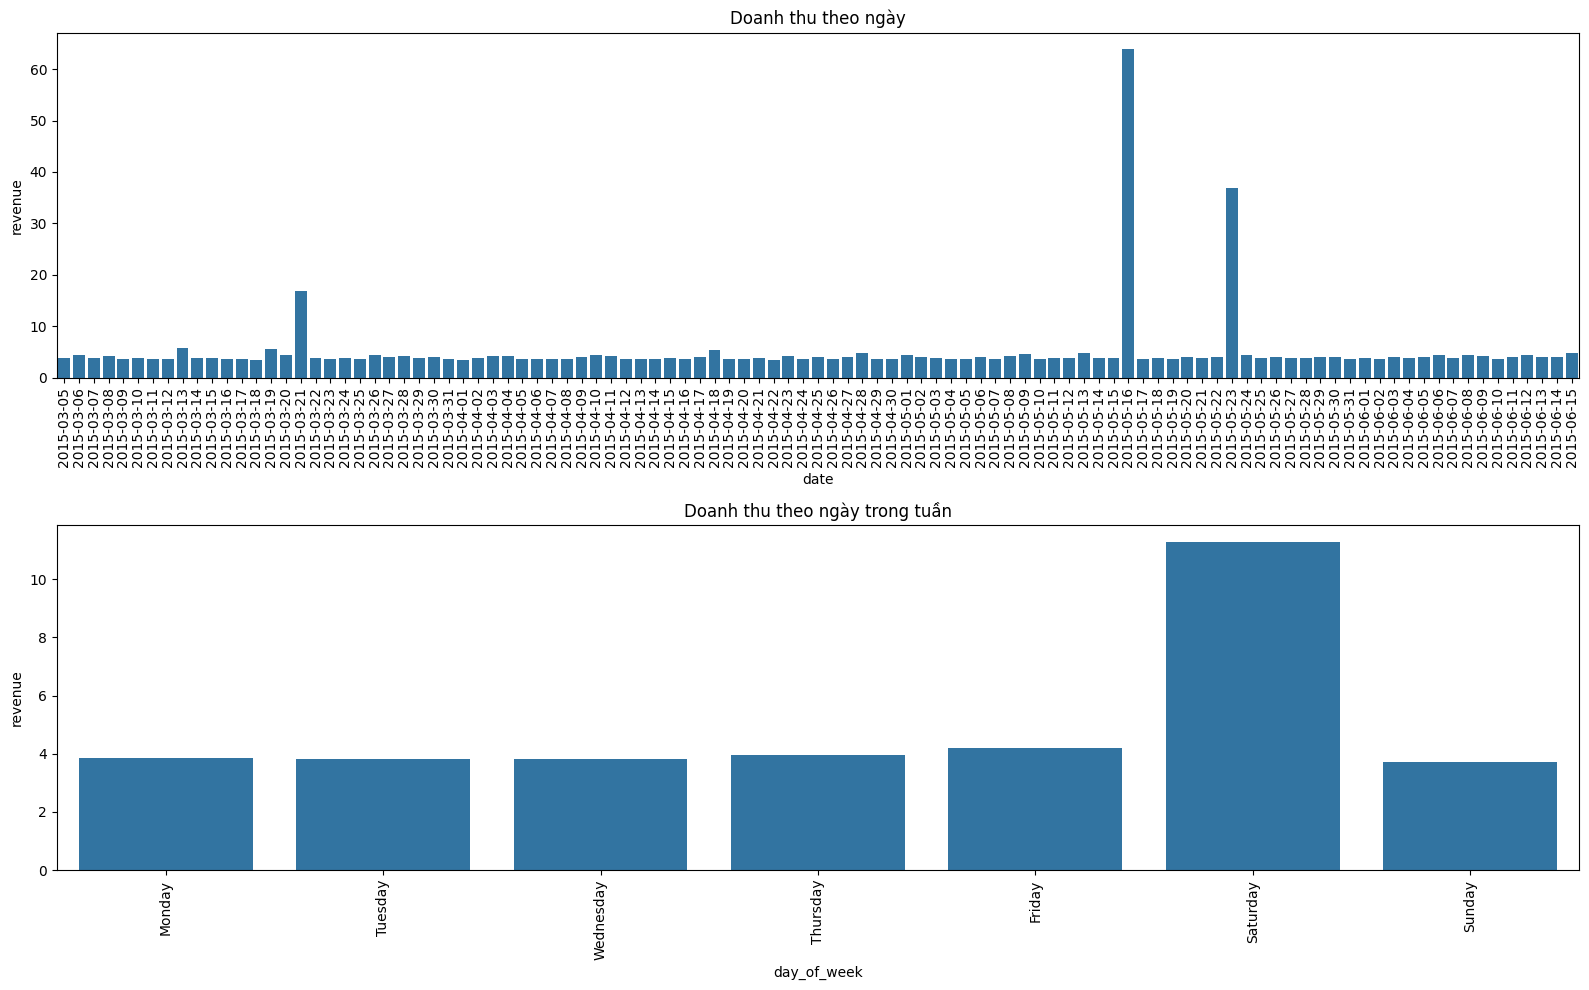

In [7]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=df_menuitem.groupby('date').agg(revenue=('SalesAmount', 'mean')),
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=df_menuitem.groupby('day_of_week').agg(revenue=('SalesAmount', 'mean')),
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.1.1 Tách outliers Quantity

In [8]:
# Tính Q1_quantity (25th percentile) và Q3_Quantity (75th percentile)
Q1_quantity = df_menuitem['Quantity'].quantile(0.25)
Q3_quantity = df_menuitem['Quantity'].quantile(0.75)

# Tính IQR_quantity
IQR_quantity = Q3_quantity - Q1_quantity

# Xác định giới hạn dưới và trên
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

# Xác định giá trị ngoại lai
outliers_quantity = df_menuitem[(df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity)].copy()
non_outliers_quantity = df_menuitem[~((df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity))].copy()

In [9]:
print("Số hàng menuitem:", df_menuitem.shape[0])
print("Tổng hàng outliers và non_outliers:", outliers_quantity.shape[0] + non_outliers_quantity.shape[0])
print("% outliers:", outliers_quantity.shape[0] / df_menuitem.shape[0] * 100)
print("Số hàng outliers:", outliers_quantity.shape[0])
print("Số hàng non_outliers:", non_outliers_quantity.shape[0])

Số hàng menuitem: 91420
Tổng hàng outliers và non_outliers: 91420
% outliers: 7.5082038941150735
Số hàng outliers: 6864
Số hàng non_outliers: 84556


### 2.1.2 Doanh thu tổng non_outliers

In [10]:
# Doanh thu tổng theo ngày
revenue_by_day = non_outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week = revenue_by_day.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()


In [11]:
revenue_by_day

,date,day_of_week,revenue
0,2015-03-05,Thursday,1246.79
1,2015-03-06,Friday,1023.68
2,2015-03-07,Saturday,834.16
3,2015-03-08,Sunday,1338.52
4,2015-03-09,Monday,1183.01
...,...,...,...
98,2015-06-11,Thursday,3693.93
99,2015-06-12,Friday,2594.26
100,2015-06-13,Saturday,2362.31
101,2015-06-14,Sunday,2827.45


In [12]:
revenue_day_of_week

,day_of_week,revenue
0,Saturday,1949.969333
1,Friday,2423.059333
2,Thursday,2921.995333
3,Sunday,2996.866667
4,Monday,3001.897333
5,Tuesday,3044.854286
6,Wednesday,3193.961429


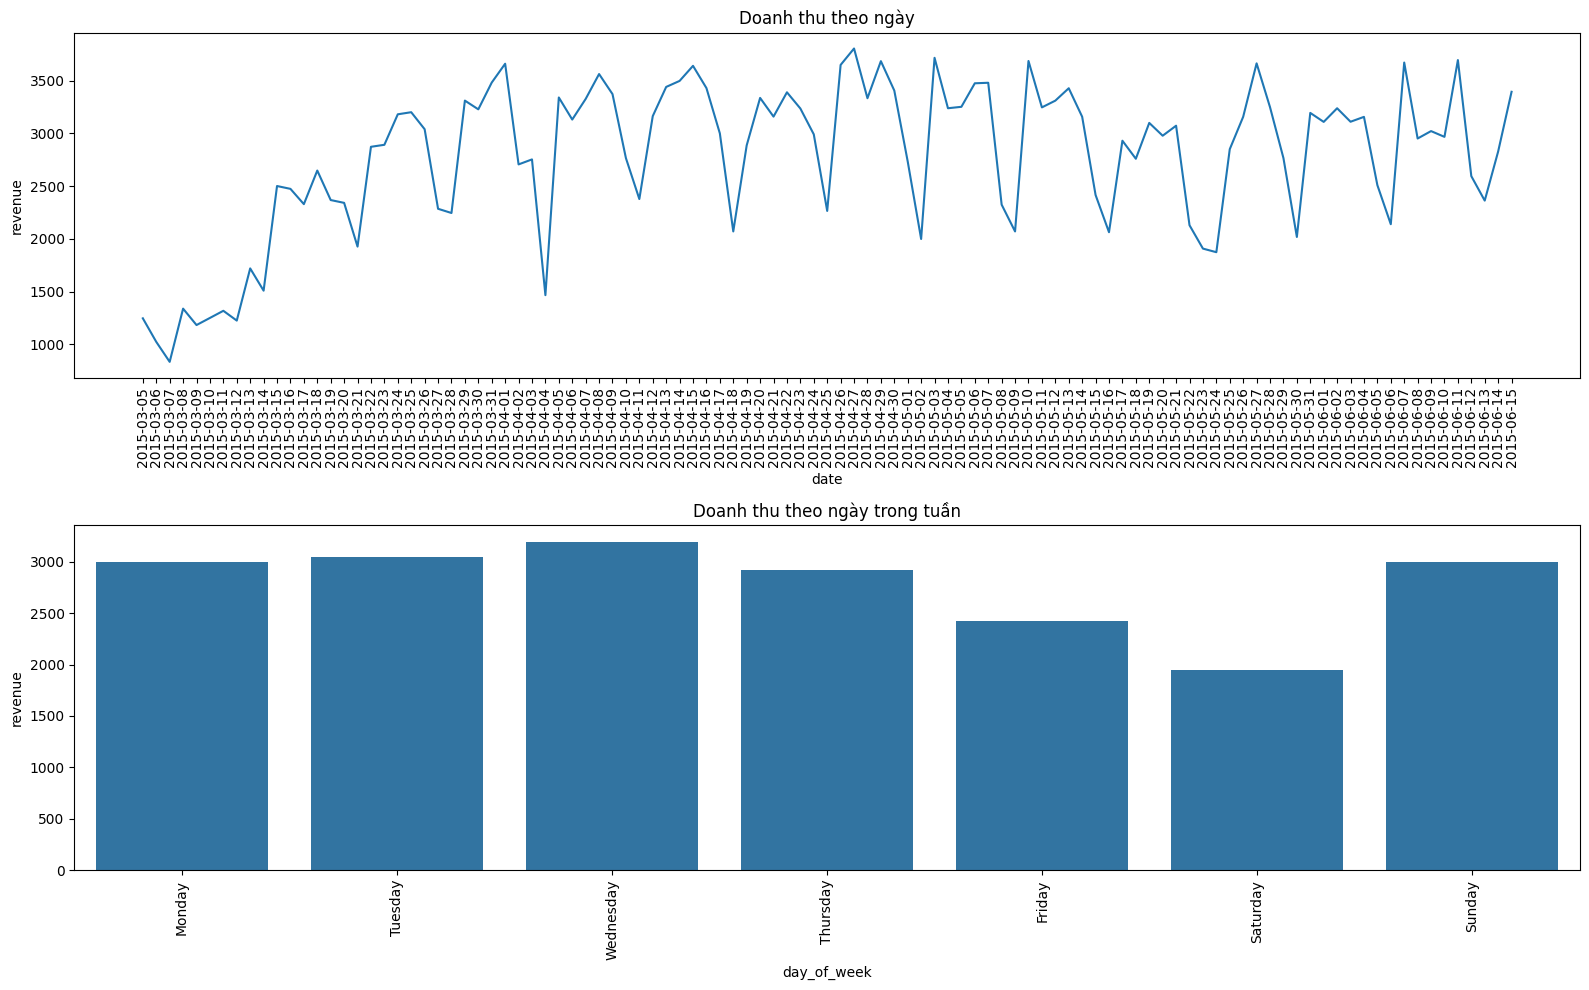

In [13]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=revenue_by_day,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần")

plt.tight_layout()
plt.show()

Note: Khoảng thời gian 2 tuần đầu hơi ít so với khoảng thời gian còn lại.
- Data có vấn đề gì không? (Không đủ dữ liệu để tìm nguyên nhân)
- Dữ liệu theo chu kỳ (biểu đồ trên) nhìn theo biểu đồ bên dưới

### 2.1.3 Doanh thu tổng outliers

In [14]:
# Doanh thu tổng theo ngày
revenue_by_day_outliers = outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week_outliers = revenue_by_day_outliers.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()


In [15]:
revenue_by_day_outliers

,date,day_of_week,revenue
0,2015-03-05,Thursday,312.00
1,2015-03-06,Friday,404.60
2,2015-03-07,Saturday,201.45
3,2015-03-08,Sunday,435.66
4,2015-03-09,Monday,257.48
...,...,...,...
98,2015-06-11,Thursday,907.29
99,2015-06-12,Friday,1081.70
100,2015-06-13,Saturday,602.72
101,2015-06-14,Sunday,664.09


In [16]:
revenue_day_of_week_outliers

,day_of_week,revenue
0,Sunday,550.019333
1,Tuesday,675.612857
2,Monday,676.065333
3,Wednesday,682.364286
4,Friday,808.228667
5,Thursday,813.735333
6,Saturday,4941.661333


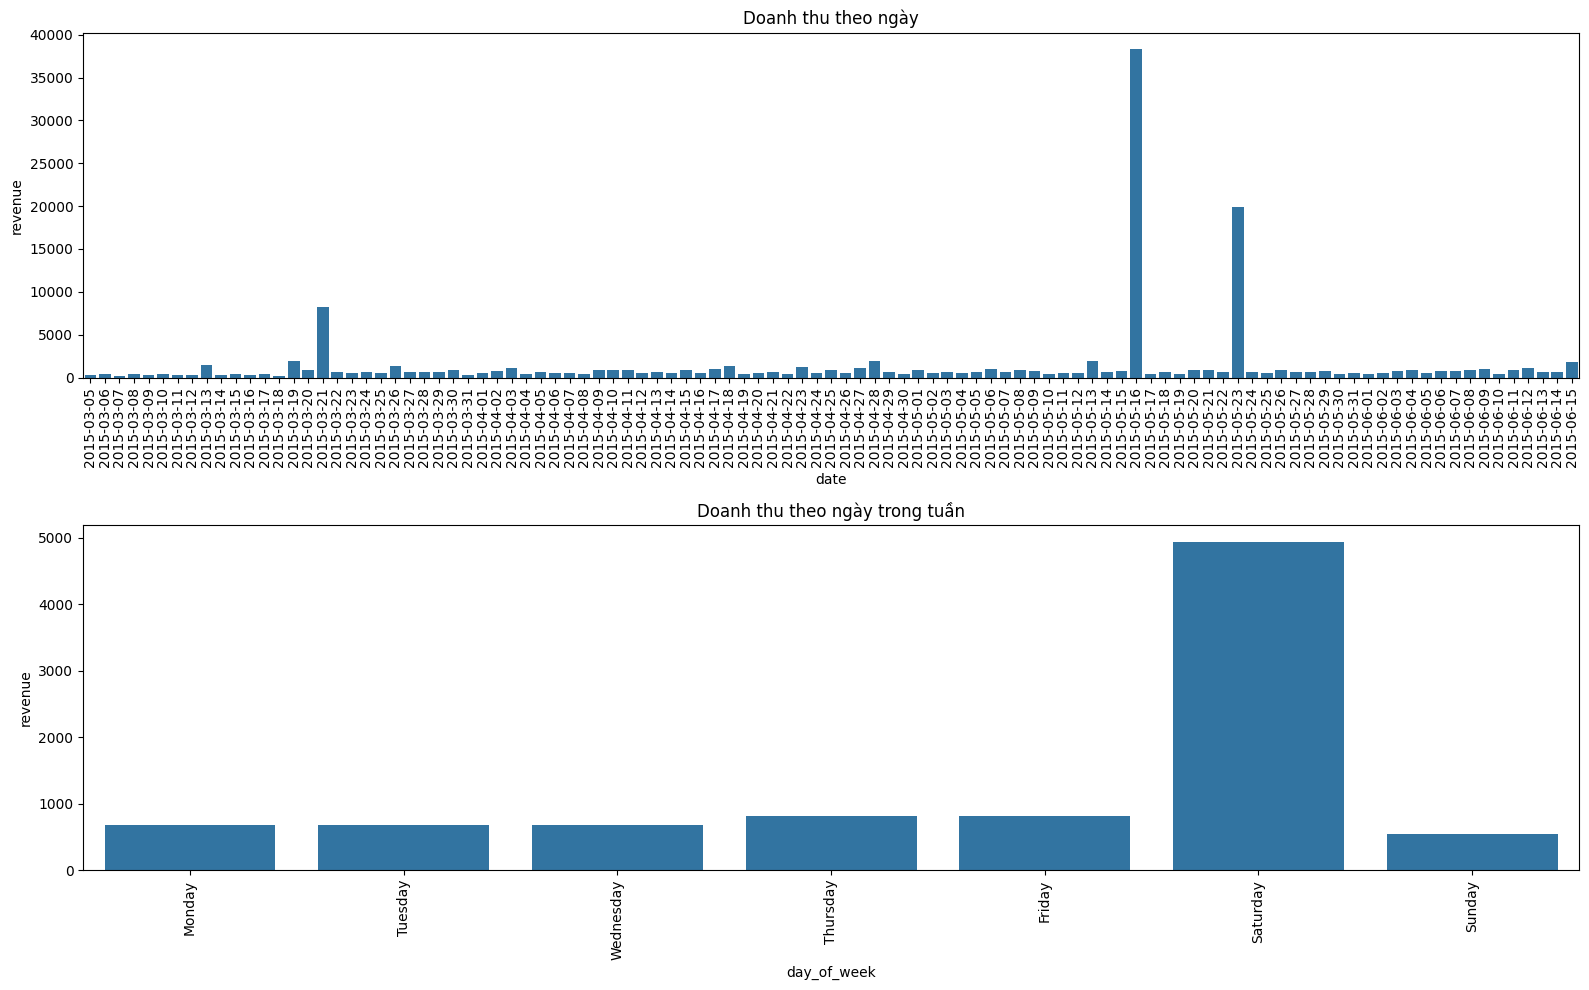

In [17]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=revenue_by_day_outliers,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week_outliers,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần")

plt.tight_layout()
plt.show()

In [18]:
revenue_by_day_outliers[revenue_by_day_outliers['date'] == "2015-03-21"]

,date,day_of_week,revenue
16,2015-03-21,Saturday,8209.38


Note: (giả thuyết) Thứ 7 có nhiều outliers
- Có thể thứ 7 khách nhỏ giảm khách lớn tăng 
- Thứ 7 đặt tiệc

Note: Outliers thường vào ngày thứ 7, có thể đặt tiệc...

## 2.2 Doanh thu trung bình mỗi đơn hàng

### 2.2.1 Doanh thu đơn hàng non_outliers

Note: Bỏ outliers
- Theo phân tích ở trên thì outlier thường xảy ra thứ 7 và xảy ra ở một vài đơn hàng (tính lại số lượng đơn hàng outlier???) có insight của nó rồi nên bỏ nó ra
- Phân tích đơn hàng đã drop các item outliers
- Nếu có đủ data có thể phân tích thêm nguồn outliers để đề xuất????

In [19]:
order = pd.merge(df_ordersale, non_outliers_quantity, on='MD5KEY_ORDERSALE', how="left")

In [20]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

In [21]:
order.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week'],
      dtype='object')

In [22]:
group_by_day = order.groupby(['date_y', 'day_of_week']).agg(
  total_order=('MD5KEY_ORDERSALE', 'nunique'),
  total_item=('Quantity', 'sum'),
  total_revenue=('SalesAmount', 'sum')).reset_index()

group_by_day['avg_item_order'] = group_by_day['total_item'] / group_by_day['total_order']
group_by_day['avg_revenue_order'] = group_by_day['total_revenue'] / group_by_day['total_order']

group_by_day.head()

,date_y,day_of_week,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,Thursday,170,366.0,1246.79,2.152941,7.334059
1,2015-03-06,Friday,133,298.0,1023.68,2.240602,7.696842
2,2015-03-07,Saturday,108,248.0,834.16,2.296296,7.723704
3,2015-03-08,Sunday,182,392.0,1338.52,2.153846,7.354505
4,2015-03-09,Monday,157,371.0,1183.01,2.363057,7.535096


In [23]:
group_by_day.describe()

,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
count,103.000000,103.000000,103.000000,103.000000,103.000000
mean,382.553398,820.932039,2783.982913,2.156237,7.323222
std,104.372986,216.522664,716.746230,0.090414,0.351278
min,108.000000,248.000000,834.160000,1.972900,6.691695
25%,313.500000,682.000000,2334.800000,2.101924,7.070576
50%,410.000000,881.000000,2990.240000,2.132150,7.211277
75%,462.000000,978.500000,3317.820000,2.198840,7.528798
max,539.000000,1165.000000,3803.730000,2.397516,8.376986


In [24]:
print(group_by_day['total_revenue'].min())
print(group_by_day['total_revenue'].max())

834.16
3803.73


In [25]:
group_by_day['day_of_week'].unique()

array(['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday'], dtype=object)

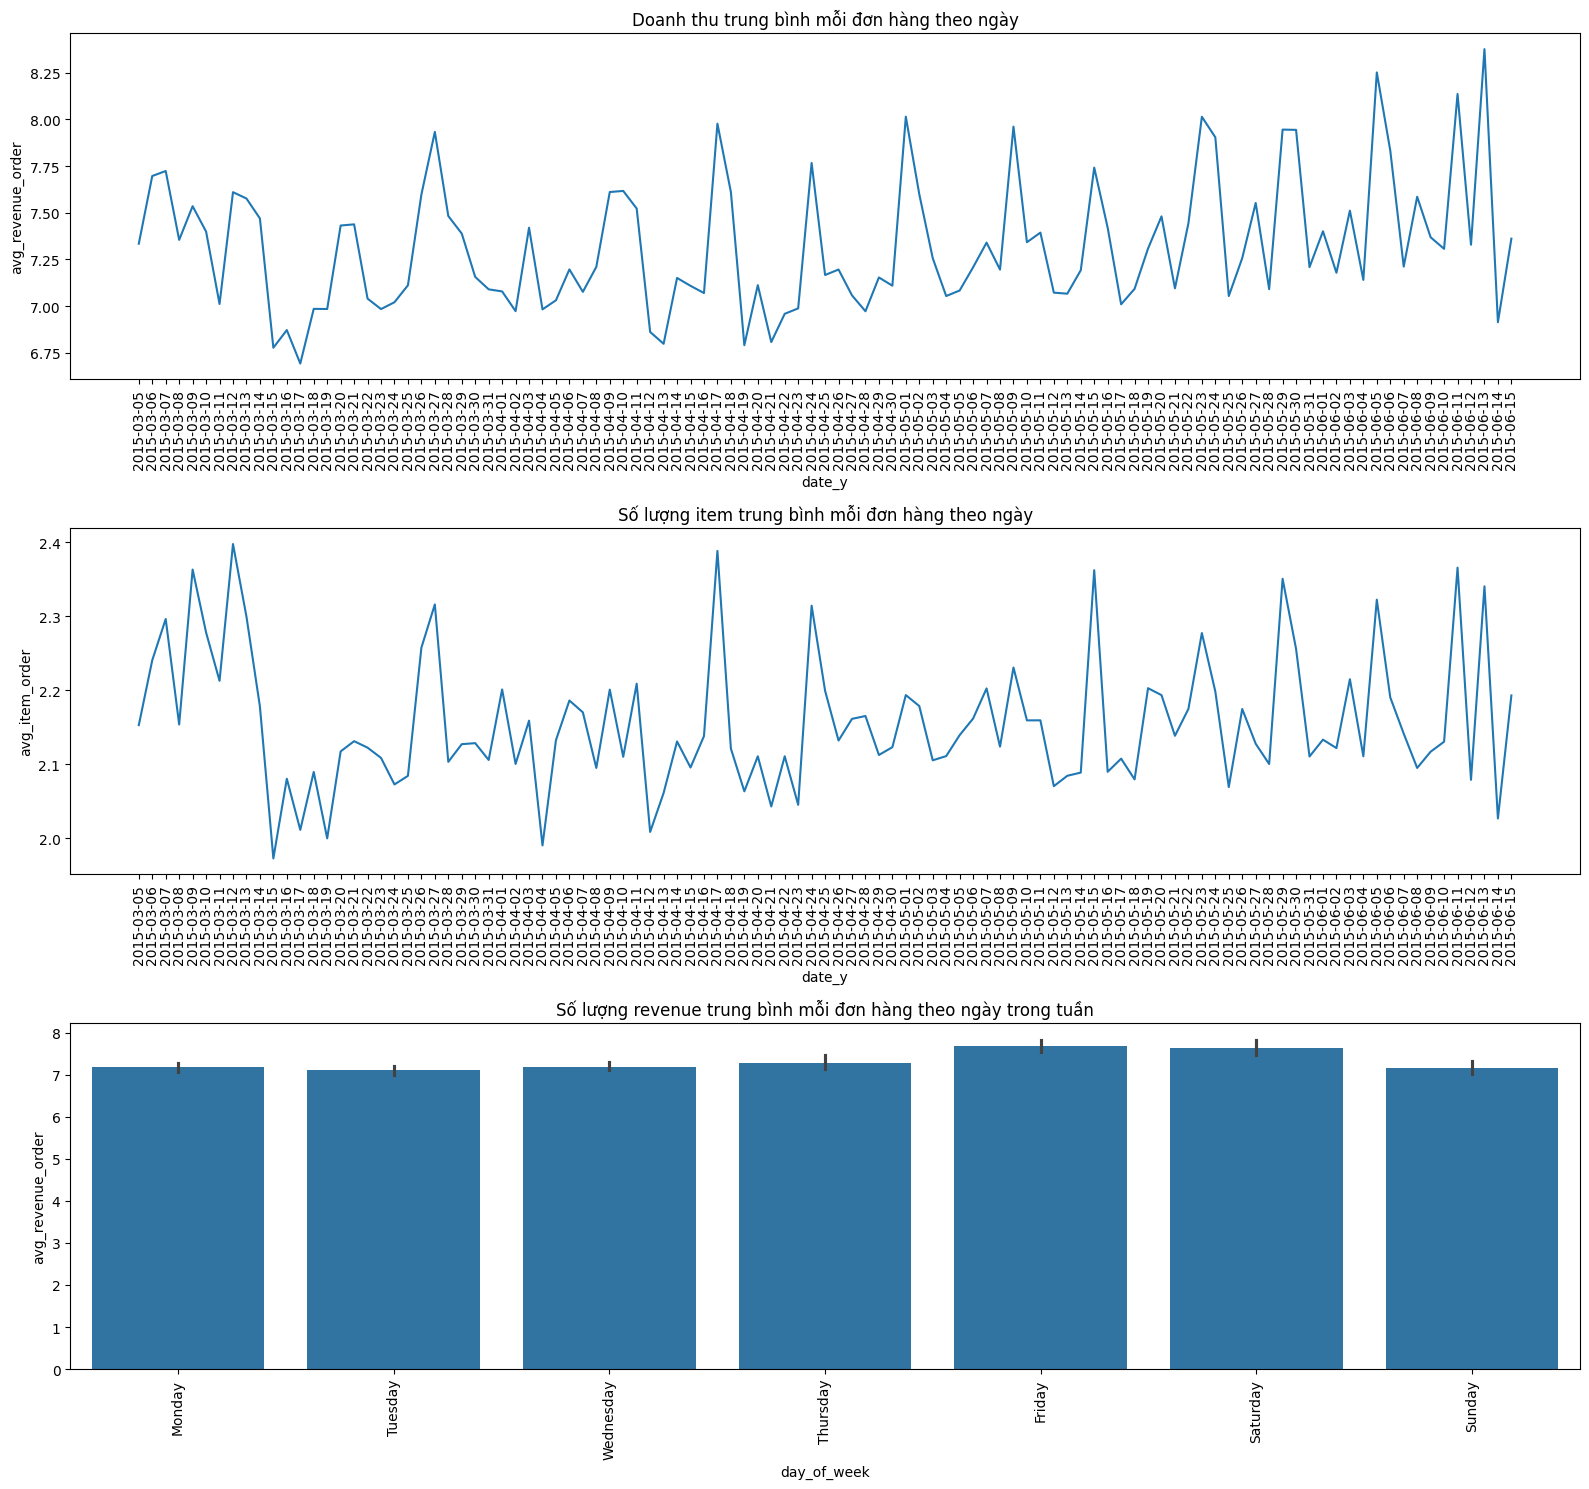

In [26]:
plt.figure(figsize=(16, 15))

plt.subplot(3, 1, 1)
sns.lineplot(data=group_by_day,
             x='date_y',
             y='avg_revenue_order')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày")

plt.subplot(3, 1, 2)
sns.lineplot(data=group_by_day,
             x='date_y',
             y='avg_item_order')
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng item trung bình mỗi đơn hàng theo ngày")

plt.subplot(3, 1, 3)
sns.barplot(data=group_by_day,
             x='day_of_week',
             y='avg_revenue_order',
             order=['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng revenue trung bình mỗi đơn hàng theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.2 Doanh thu đơn hàng outliers - Bỏ

In [27]:
group_by_day_outliers = outliers_quantity.groupby('date').agg(
  total_order=('MD5KEY_ORDERSALE', 'nunique'),
  total_item=('Quantity', 'sum'),
  total_revenue=('SalesAmount', 'sum')).reset_index()

group_by_day_outliers['avg_item_order'] = group_by_day_outliers['total_item'] / group_by_day_outliers['total_order']
group_by_day_outliers['avg_revenue_order'] = group_by_day_outliers['total_revenue'] / group_by_day_outliers['total_order']

group_by_day_outliers

,date,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,32,78,312.00,2.437500,9.750000
1,2015-03-06,26,69,404.60,2.653846,15.561538
2,2015-03-07,24,54,201.45,2.250000,8.393750
3,2015-03-08,37,95,435.66,2.567568,11.774595
4,2015-03-09,27,66,257.48,2.444444,9.536296
...,...,...,...,...,...,...
98,2015-06-11,69,181,907.29,2.623188,13.149130
99,2015-06-12,72,220,1081.70,3.055556,15.023611
100,2015-06-13,54,146,602.72,2.703704,11.161481
101,2015-06-14,58,138,664.09,2.379310,11.449828


In [28]:
print(group_by_day_outliers['total_revenue'].min())
print(group_by_day_outliers['total_revenue'].max())

201.45000000000002
38310.49


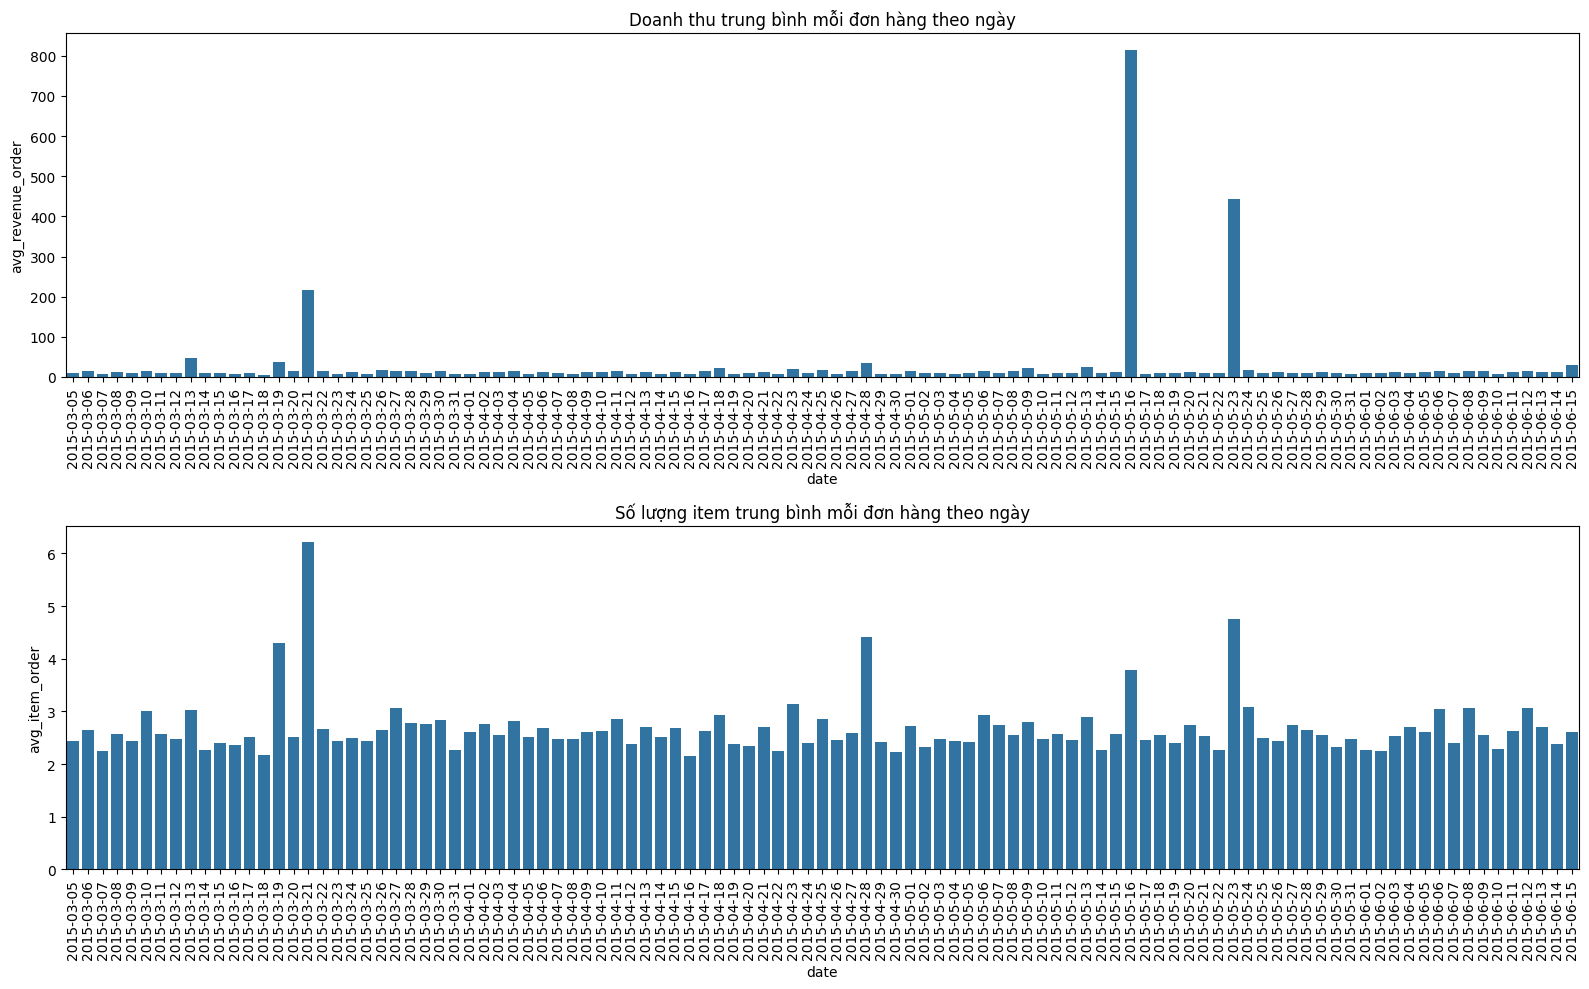

In [29]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=group_by_day_outliers,
             x='date',
             y='avg_revenue_order')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=group_by_day_outliers,
             x='date',
             y='avg_item_order')
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng item trung bình mỗi đơn hàng theo ngày")

plt.tight_layout()
plt.show()

## 2.3 Doanh thu từng cửa hàng

### 2.3.1 Doanh thu non_outliers

In [30]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

In [31]:
group_by_day_store = non_outliers_quantity.groupby(['date', 'StoreNumber']).agg(
  total_order=('MD5KEY_ORDERSALE', 'nunique'),
  total_item=('Quantity', 'sum'),
  total_revenue=('SalesAmount', 'sum')).reset_index()

group_by_day_store['avg_item_order'] = group_by_day_store['total_item'] / group_by_day_store['total_order']
group_by_day_store['avg_revenue_order'] = group_by_day_store['total_revenue'] / group_by_day_store['total_order']

group_by_day_store

,date,StoreNumber,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,12631,100,195,666.39,1.950000,6.663900
1,2015-03-05,46673,70,171,580.40,2.442857,8.291429
2,2015-03-06,12631,91,202,697.34,2.219780,7.663077
3,2015-03-06,20974,1,2,8.63,2.000000,8.630000
4,2015-03-06,46673,41,94,317.71,2.292683,7.749024
...,...,...,...,...,...,...,...
391,2015-06-14,46673,68,144,493.44,2.117647,7.256471
392,2015-06-15,4904,174,358,1205.85,2.057471,6.930172
393,2015-06-15,12631,109,223,751.74,2.045872,6.896697
394,2015-06-15,20974,96,214,782.33,2.229167,8.149271


In [32]:
store_number = group_by_day_store['StoreNumber'].unique()
store_number

array([12631, 46673, 20974,  4904])

#### 2.3.1.1 Doanh thu trung bình

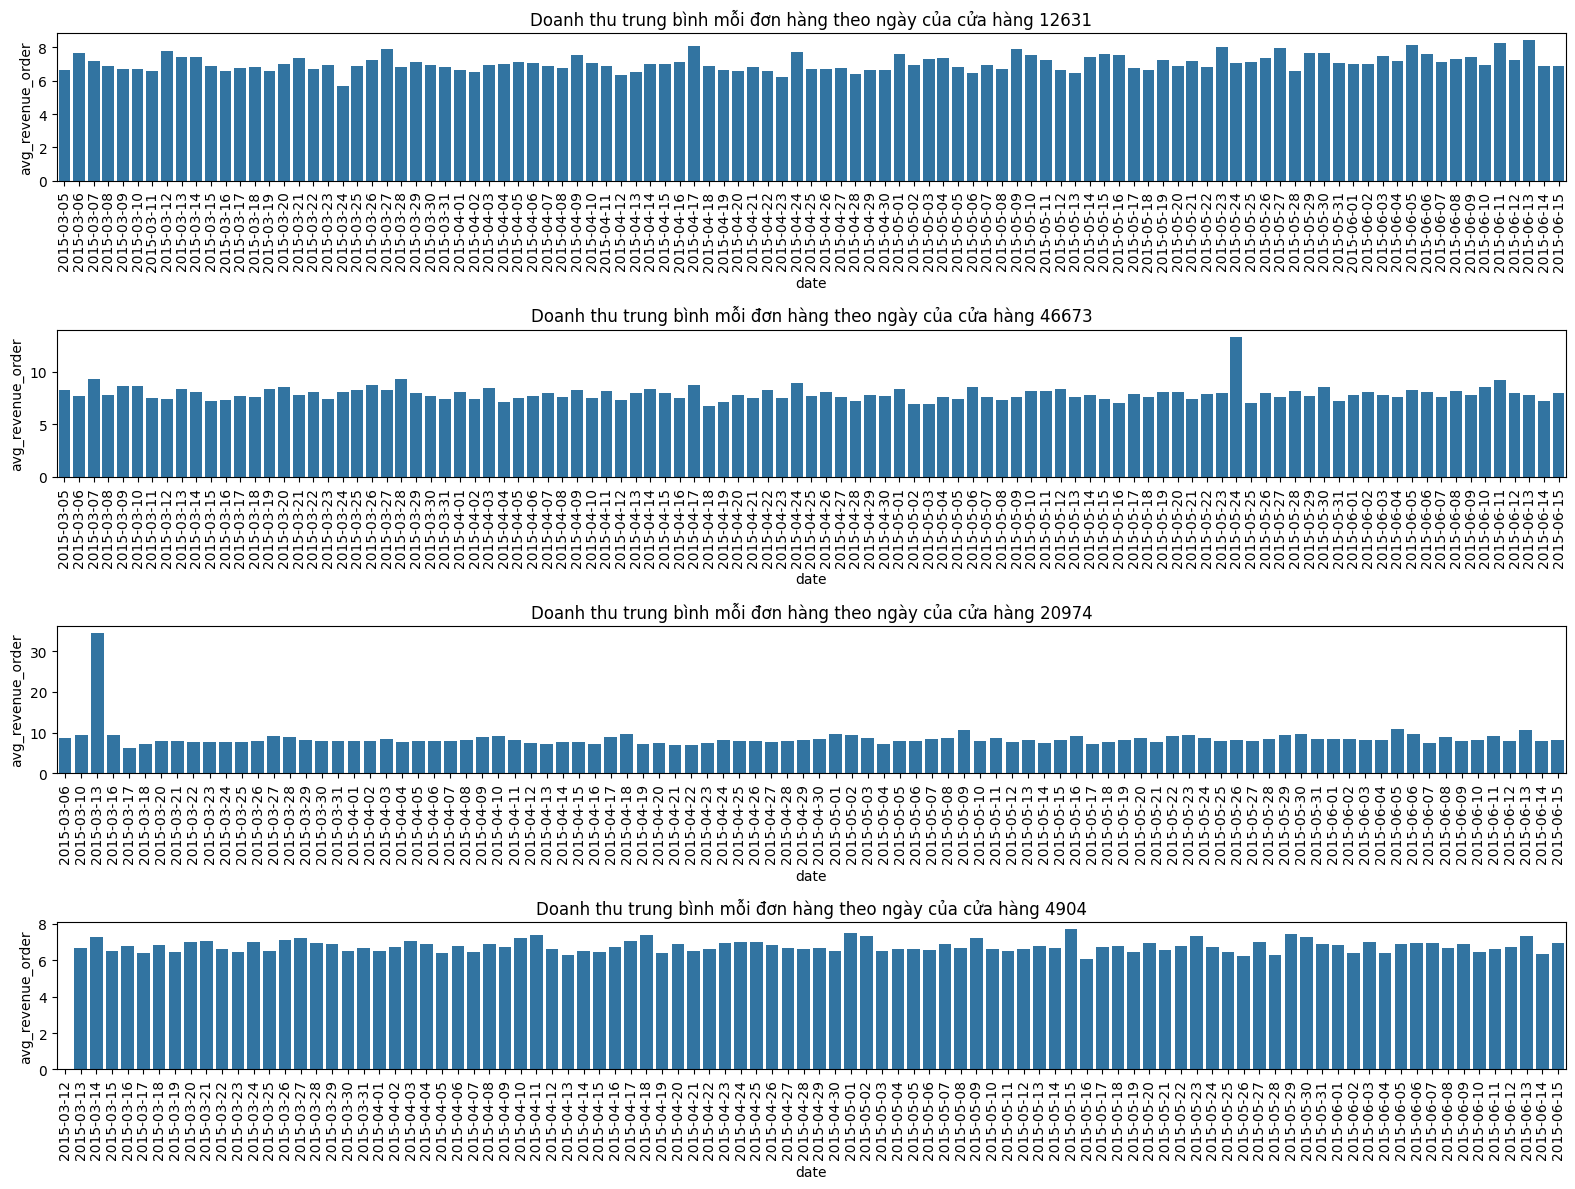

In [33]:
plt.figure(figsize=(16, 12))

for index, store in enumerate(store_number, start=1):
  plt.subplot(4, 1, index)
  sns.barplot(data=group_by_day_store[group_by_day_store['StoreNumber'] == store],
              x='date',
              y='avg_revenue_order')
  plt.xticks(rotation=90, ha='center')
  plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")
  
plt.tight_layout()
plt.show()

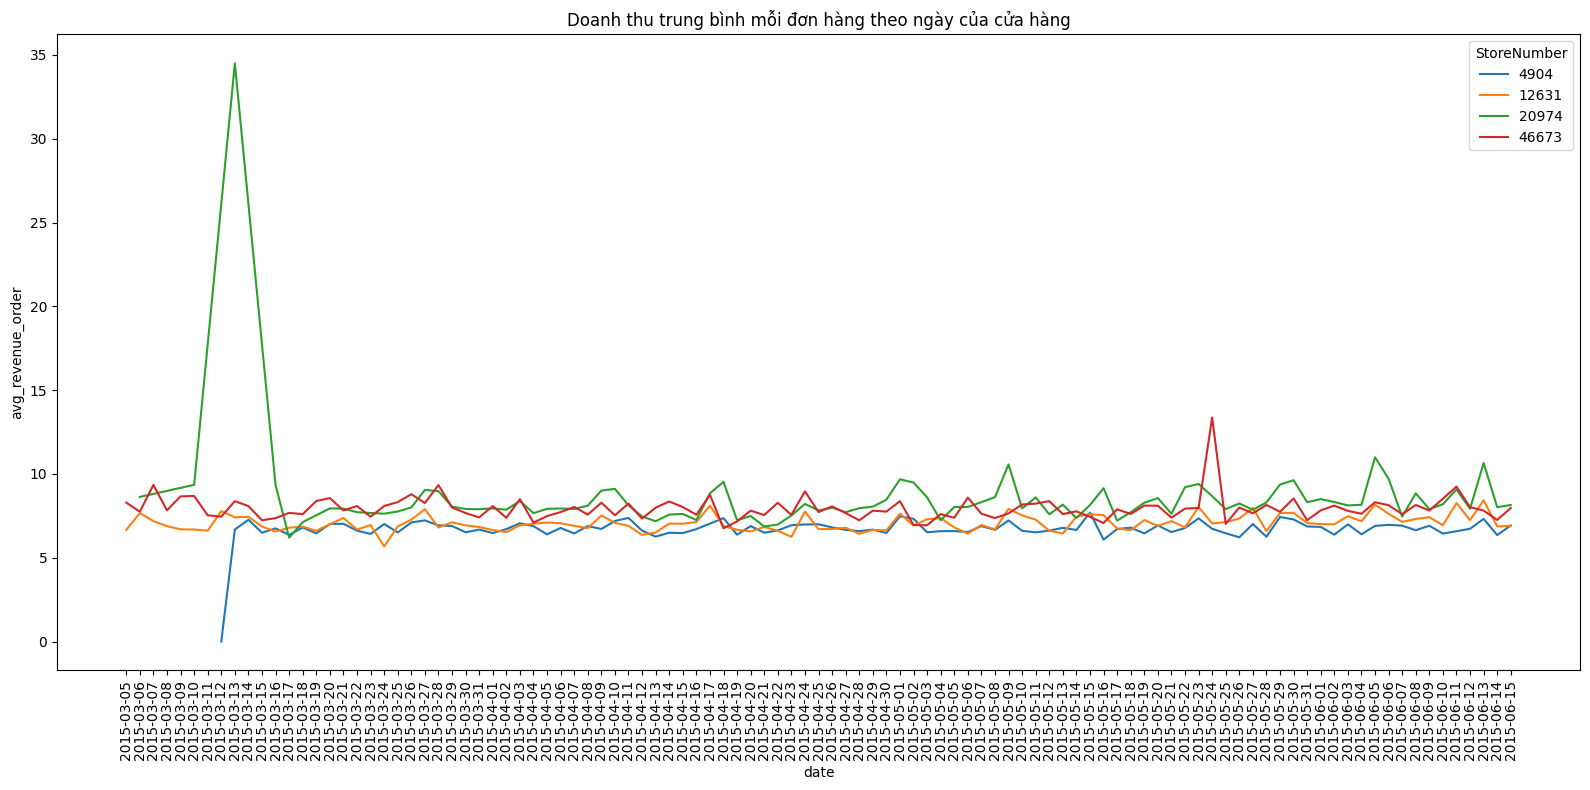

In [34]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=group_by_day_store,
            x='date',
            y='avg_revenue_order',
            hue="StoreNumber",
            palette='tab10')
plt.xticks(rotation=90, ha='center')
plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng")

plt.tight_layout()
plt.show()

In [35]:
group_by_day_store.head()

,date,StoreNumber,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,12631,100,195,666.39,1.950000,6.663900
1,2015-03-05,46673,70,171,580.40,2.442857,8.291429
2,2015-03-06,12631,91,202,697.34,2.219780,7.663077
3,2015-03-06,20974,1,2,8.63,2.000000,8.630000
4,2015-03-06,46673,41,94,317.71,2.292683,7.749024


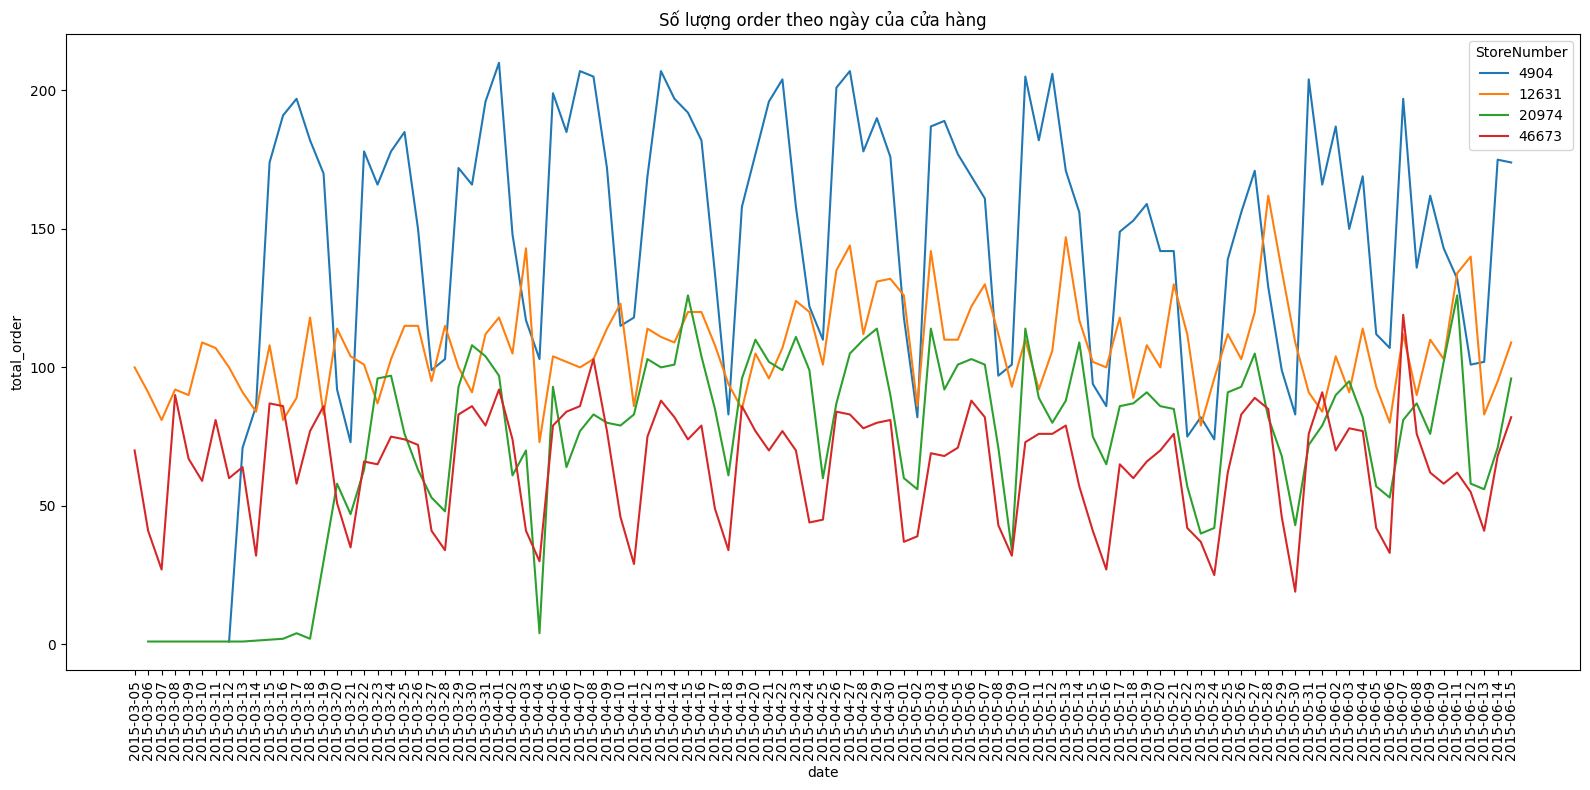

In [36]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=group_by_day_store,
            x='date',
            y='total_order',
            hue="StoreNumber",
            palette='tab10')
plt.xticks(rotation=90, ha='center')
plt.title(f"Số lượng order theo ngày của cửa hàng")

plt.tight_layout()
plt.show()

In [37]:
# check xem lại dữ liệu hai biểu đồ trên
# Doanh thu trung bình mỗi order và số lượng order mỗi ngày
check_order_store = group_by_day_store.groupby('StoreNumber').agg(
  total_order=('total_order', 'sum'),
  total_revenue=('total_revenue', 'sum')).reset_index()

check_order_store['avg_revenue_order'] = check_order_store['total_revenue']/check_order_store['total_order']

check_order_store

,StoreNumber,total_order,total_revenue,avg_revenue_order
0,4904,14401,96817.28,6.722955
1,12631,11026,77804.39,7.056447
2,20974,7260,59145.76,8.146799
3,46673,6716,52982.81,7.889043


#### 2.3.1.2 Đơn hàng trung bình

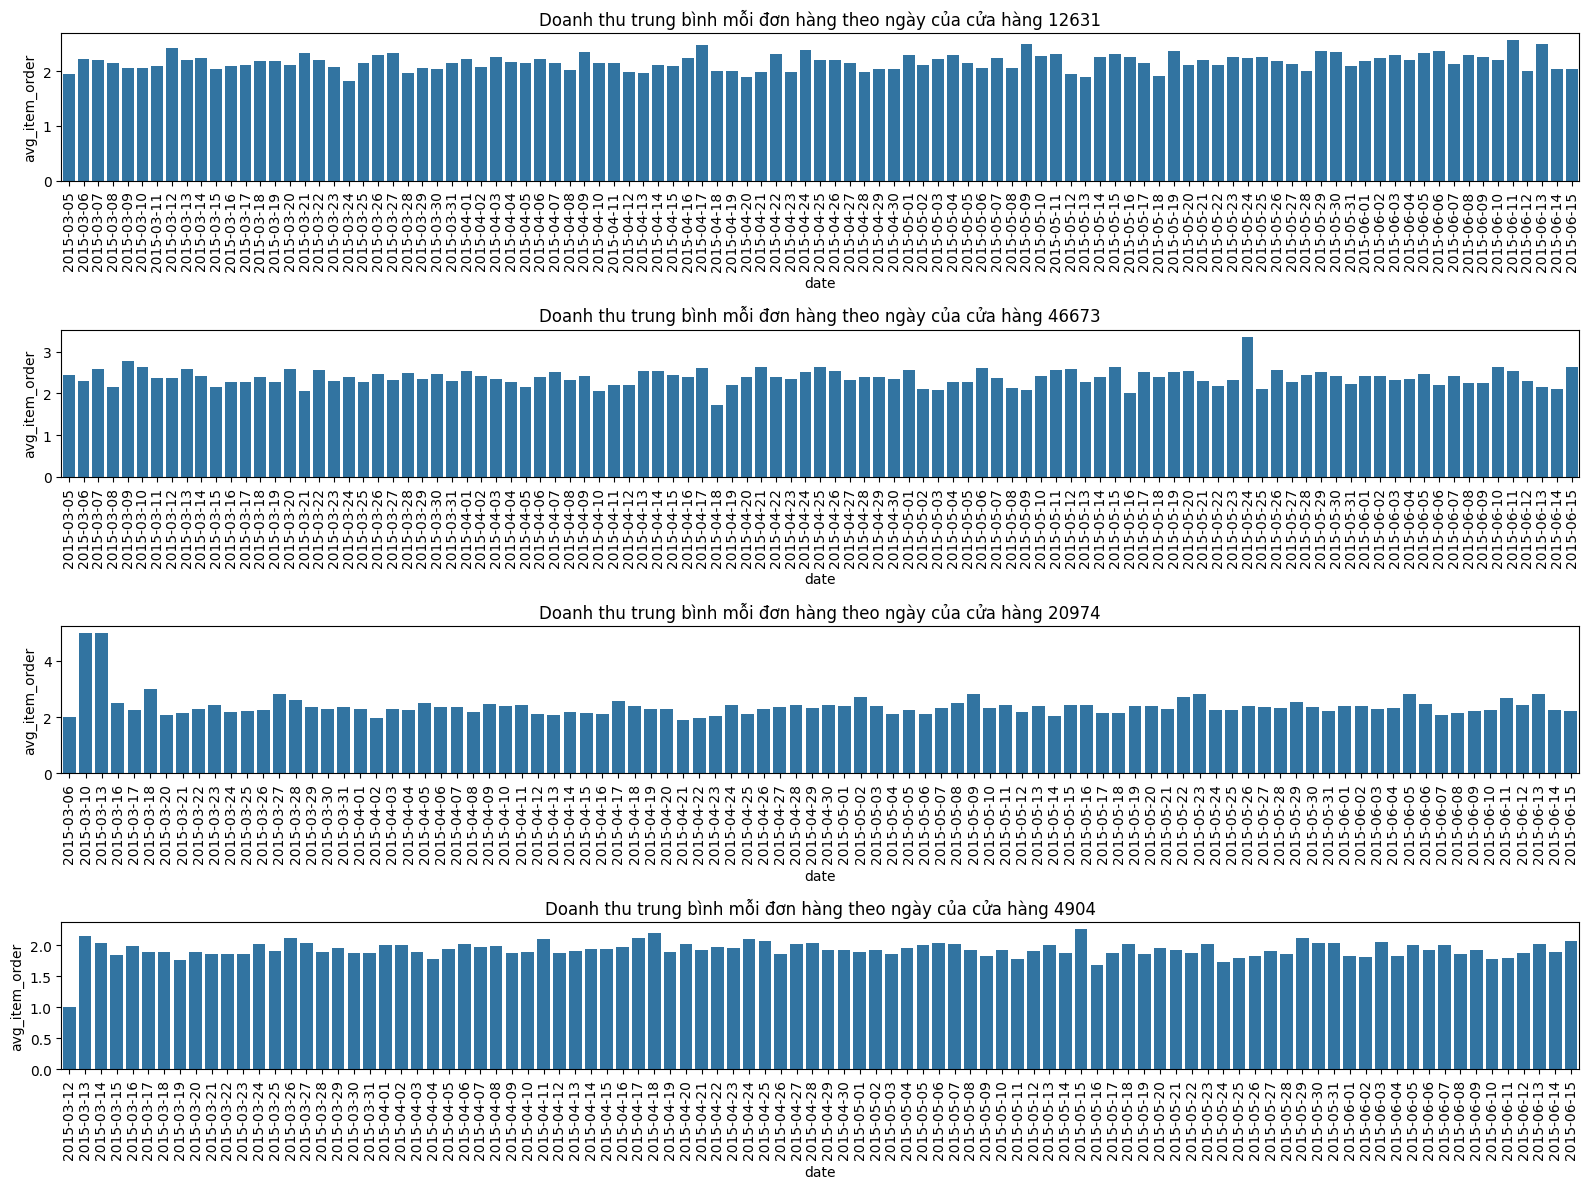

In [38]:
plt.figure(figsize=(16, 12))

for index, store in enumerate(store_number, start=1):
  plt.subplot(4, 1, index)
  sns.barplot(data=group_by_day_store[group_by_day_store['StoreNumber'] == store],
              x='date',
              y='avg_item_order')
  plt.xticks(rotation=90, ha='center')
  plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")
  
plt.tight_layout()
plt.show()

### 2.3.2 Doanh thu outliers

In [39]:
group_by_day_store_outliers = outliers_quantity.groupby(['date', 'StoreNumber']).agg(
  total_order=('MD5KEY_ORDERSALE', 'nunique'),
  total_item=('Quantity', 'sum'),
  total_revenue=('SalesAmount', 'sum')).reset_index()

group_by_day_store_outliers['avg_item_order'] = group_by_day_store_outliers['total_item'] / group_by_day_store_outliers['total_order']
group_by_day_store_outliers['avg_revenue_order'] = group_by_day_store_outliers['total_revenue'] / group_by_day_store_outliers['total_order']

group_by_day_store_outliers

,date,StoreNumber,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,12631,23,57,200.90,2.478261,8.734783
1,2015-03-05,46673,9,21,111.10,2.333333,12.344444
2,2015-03-06,12631,18,45,278.12,2.500000,15.451111
3,2015-03-06,46673,8,24,126.48,3.000000,15.810000
4,2015-03-07,12631,19,44,165.65,2.315789,8.718421
...,...,...,...,...,...,...,...
385,2015-06-14,46673,7,22,92.62,3.142857,13.231429
386,2015-06-15,4904,14,32,77.40,2.285714,5.528571
387,2015-06-15,12631,14,34,130.44,2.428571,9.317143
388,2015-06-15,20974,16,44,222.70,2.750000,13.918750


In [40]:
store_number_outliers = group_by_day_store['StoreNumber'].unique()
store_number_outliers

array([12631, 46673, 20974,  4904])

#### 2.3.2.1 Doanh thu trung bình

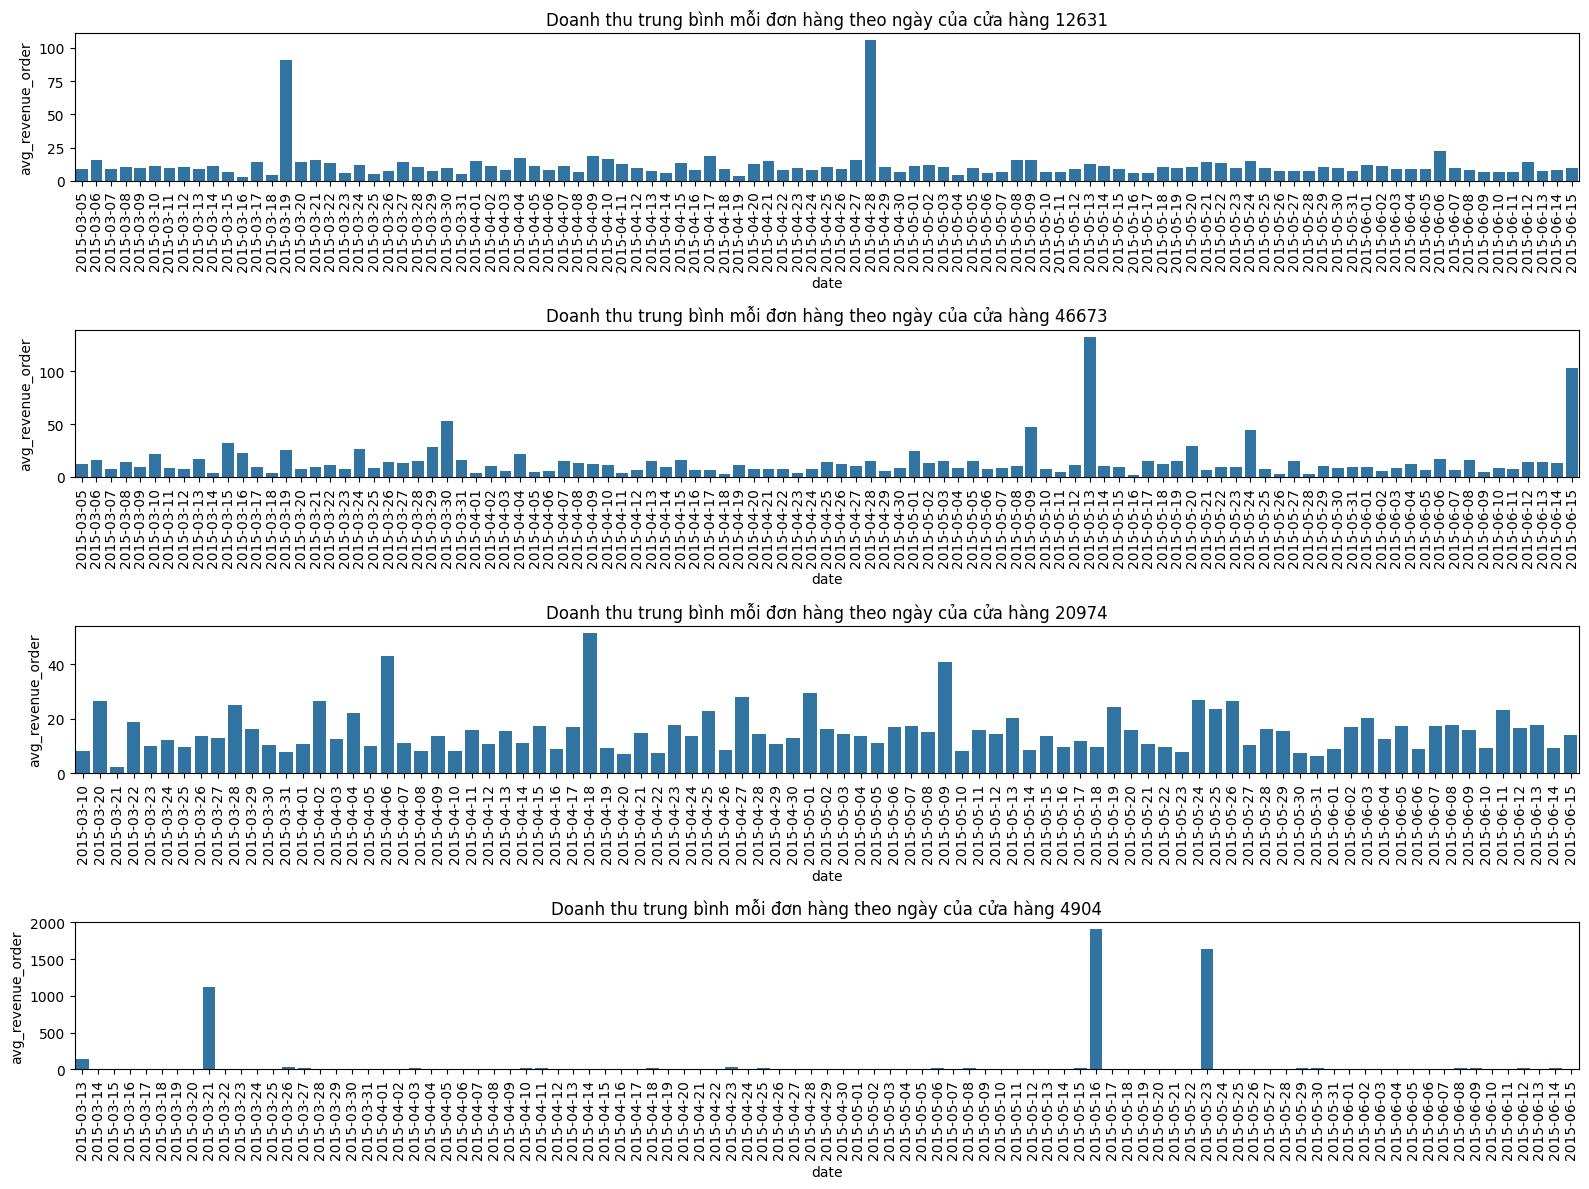

In [41]:
plt.figure(figsize=(16, 12))

for index, store in enumerate(store_number, start=1):
  plt.subplot(4, 1, index)
  sns.barplot(data=group_by_day_store_outliers[group_by_day_store_outliers['StoreNumber'] == store],
              x='date',
              y='avg_revenue_order')
  plt.xticks(rotation=90, ha='center')
  plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")
  
plt.tight_layout()
plt.show()

Note: Check sote 4904

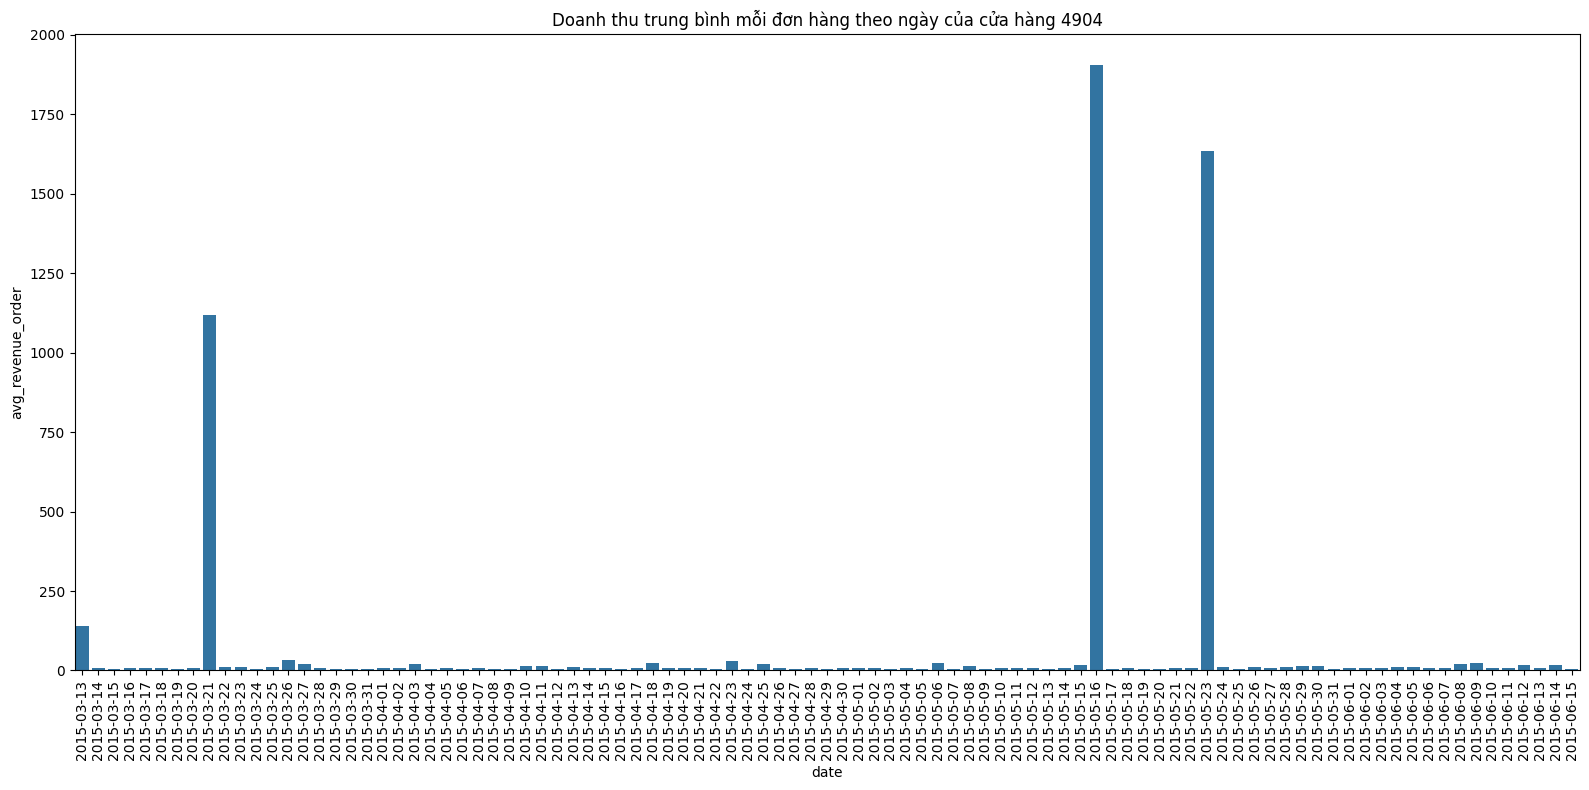

In [42]:
plt.figure(figsize=(16, 8))
sns.barplot(data=group_by_day_store_outliers[group_by_day_store_outliers['StoreNumber'] == 4904],
            x='date',
            y='avg_revenue_order')
plt.xticks(rotation=90, ha='center')
plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")

plt.tight_layout()
plt.show()

#### 2.3.2.2 Đơn hàng trung bình

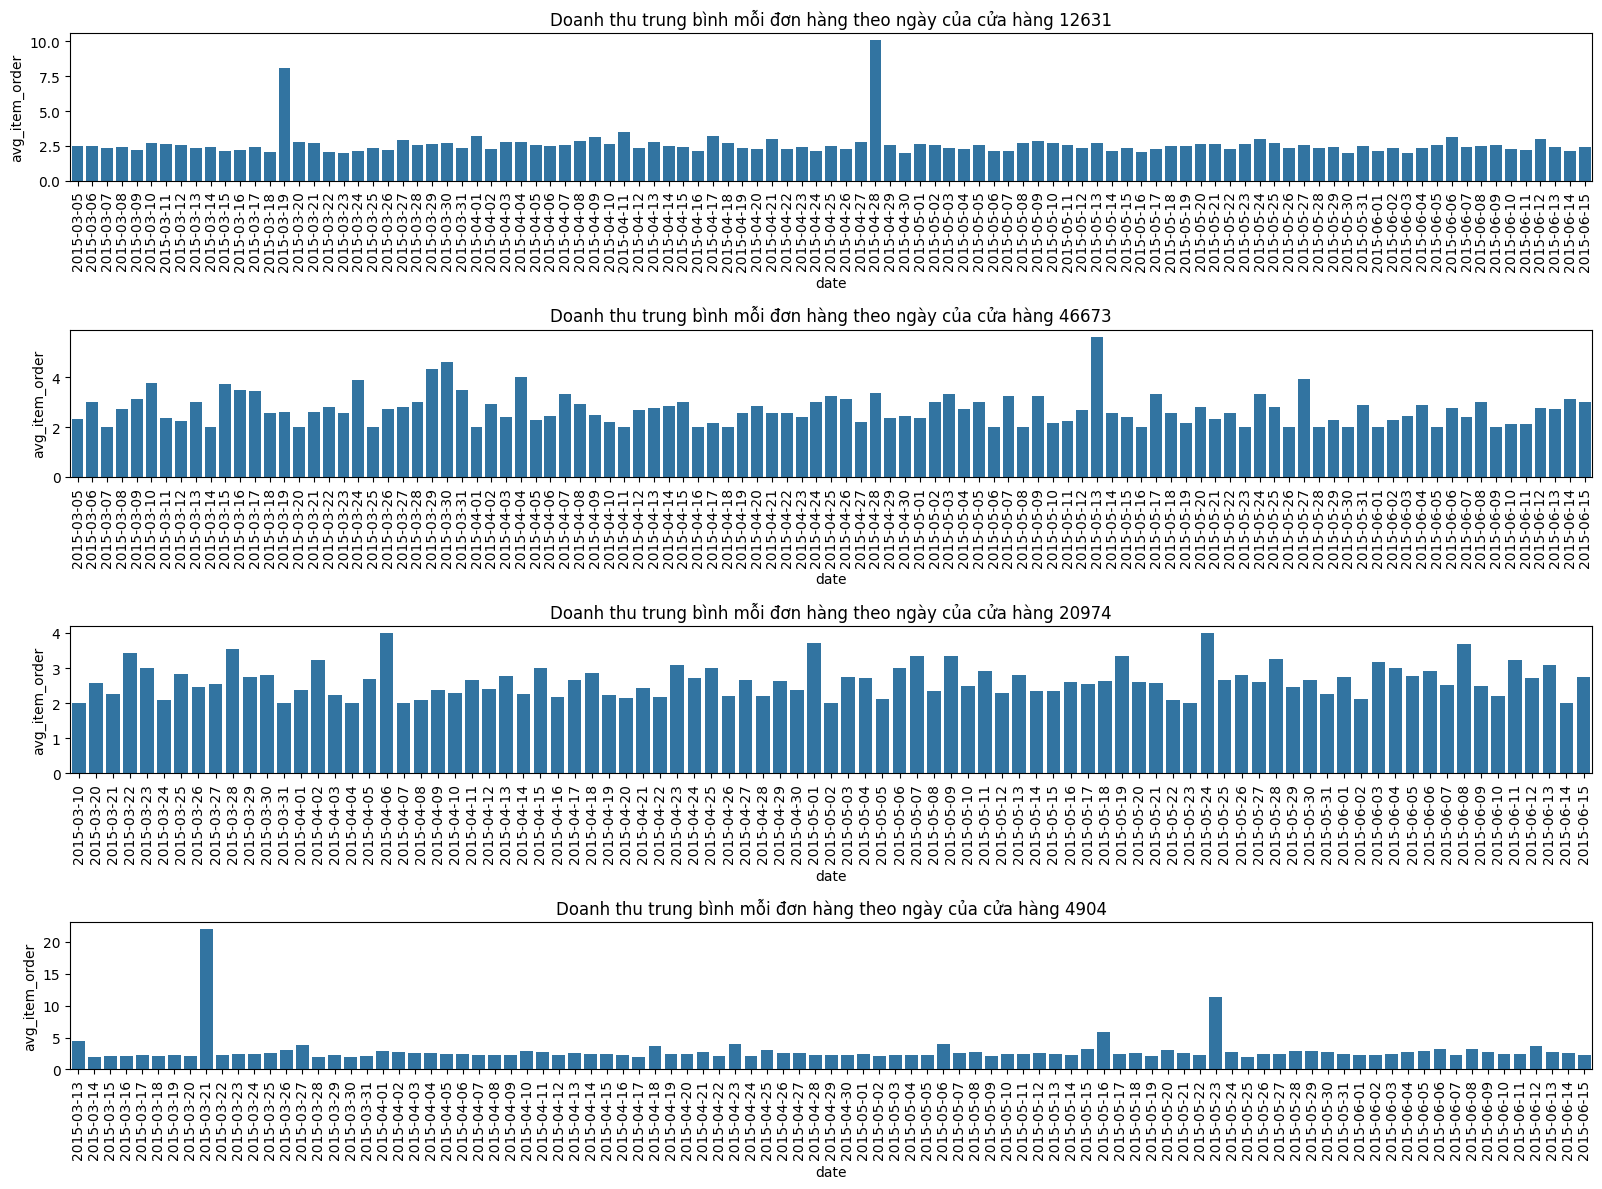

In [43]:
plt.figure(figsize=(16, 12))

for index, store in enumerate(store_number, start=1):
  plt.subplot(4, 1, index)
  sns.barplot(data=group_by_day_store_outliers[group_by_day_store_outliers['StoreNumber'] == store],
              x='date',
              y='avg_item_order')
  plt.xticks(rotation=90, ha='center')
  plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")
  
plt.tight_layout()
plt.show()

## 2.4 Doanh thu trừ thuế

# 3. So sánh doanh thu từng cửa hàng
So sánh doanh thu của từng cửa hàng để xác định cửa hàng có doanh thu cao nhất và thấp nhất

## 3.1 Tổng

In [44]:
df_menuitem.head()

,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date,SalesAmount,day_of_week
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05,7.75,Thursday
1,003E4E20196B2F5BDD33CE06D2943EF4,14811D4F3458058007B0B6908C2DA393,Fountain,Fountain Drink 21 oz.,21oz Fountain Drink,46673,0.1530,1.70,0.00,1.70,1,212000126,280,2015-03-05,1.70,Thursday
2,012A55E5551C95A559A7B074AE85117E,22FA6C39B7A15ABB6EB568E66A6B30E1,6 Inch,6 Inch Sub,B.M.T. 6 inch,12631,0.3230,3.64,0.61,4.25,1,121000008,8,2015-03-05,3.64,Thursday
3,01B07F1C6DC6945796571FC78735DA16,915B69612845BBD974C39AC105F5CA8C,6 Inch,6 Inch Sub,Veggie Delite 6 inch,12631,0.3328,3.75,0.00,3.75,1,121000001,91,2015-03-05,3.75,Thursday
4,02DE19974DE5304BF243A1C2EC639495,CD6386C802450EDCF13A3D112D1F86EC,Add On,Add On 6in Portion,Avocado Add6in,12631,0.0443,0.50,0.00,0.50,1,175000062,564,2015-03-05,0.50,Thursday


In [45]:
df_menuitem.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum'))

,revenue
StoreNumber,
4904,179129.39
12631,100888.28
20974,77242.96
46673,65346.94


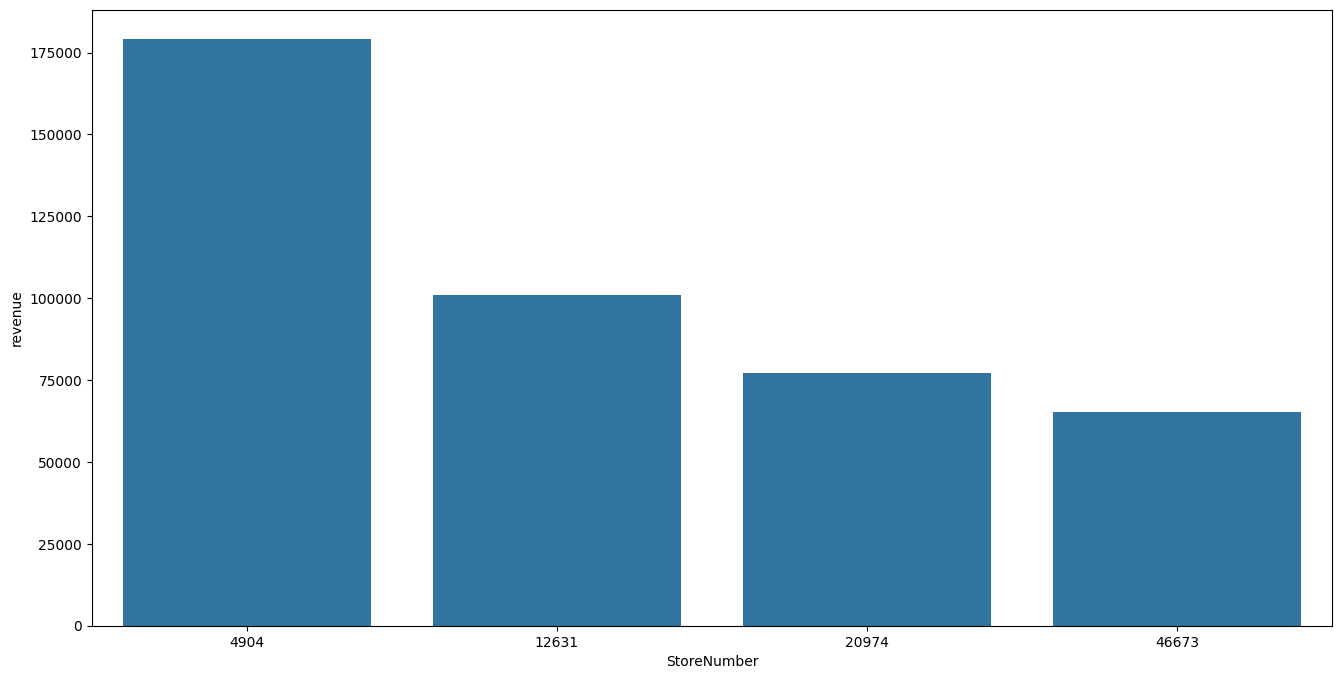

In [46]:
plt.figure(figsize=(16, 8))

sns.barplot(data=df_menuitem.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='StoreNumber',
            y='revenue')

plt.show()

## 3.2 Non-outliers

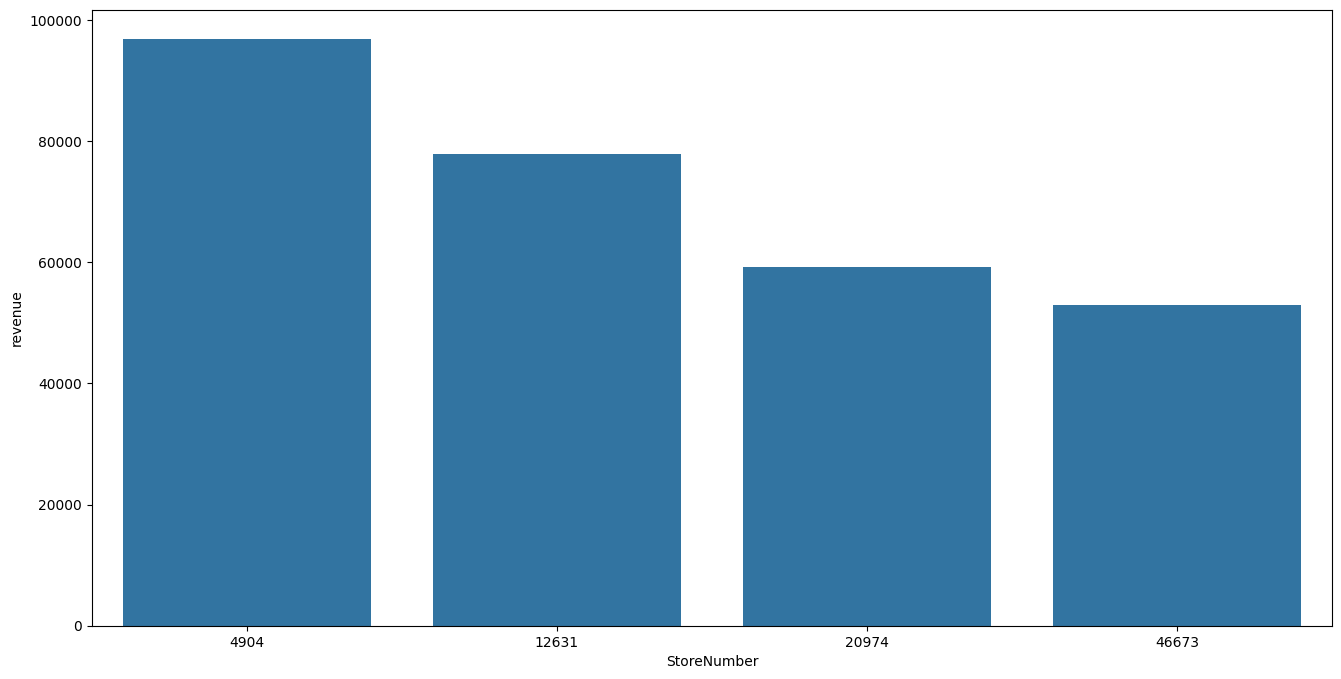

In [47]:
plt.figure(figsize=(16, 8))

sns.barplot(data=non_outliers_quantity.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='StoreNumber',
            y='revenue')

plt.show()

## 3.3 Outliers - Bỏ

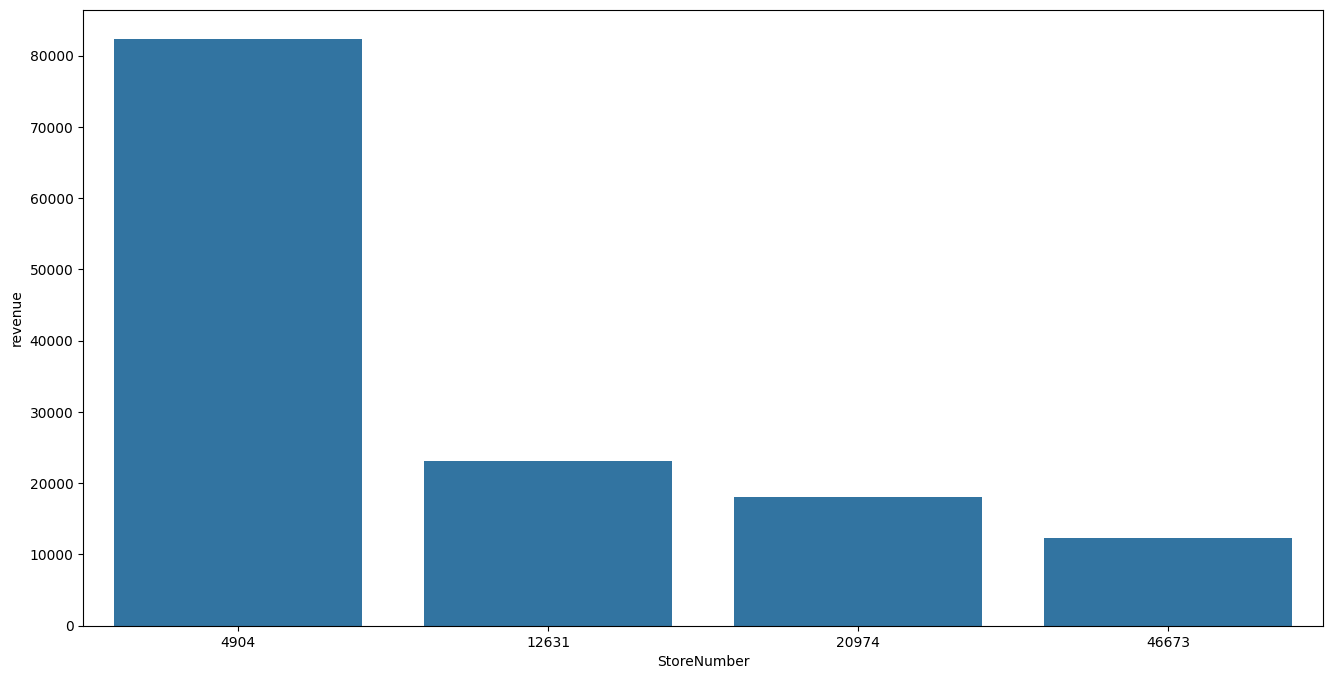

In [48]:
plt.figure(figsize=(16, 8))

sns.barplot(data=outliers_quantity.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='StoreNumber',
            y='revenue')

plt.show()

# 4. Phân tích tác động của giảm giá
Phân tích tác động của việc giảm giá lên số lượng bán ra và doanh thu.

In [49]:
df_menuitem.head()

,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date,SalesAmount,day_of_week
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05,7.75,Thursday
1,003E4E20196B2F5BDD33CE06D2943EF4,14811D4F3458058007B0B6908C2DA393,Fountain,Fountain Drink 21 oz.,21oz Fountain Drink,46673,0.1530,1.70,0.00,1.70,1,212000126,280,2015-03-05,1.70,Thursday
2,012A55E5551C95A559A7B074AE85117E,22FA6C39B7A15ABB6EB568E66A6B30E1,6 Inch,6 Inch Sub,B.M.T. 6 inch,12631,0.3230,3.64,0.61,4.25,1,121000008,8,2015-03-05,3.64,Thursday
3,01B07F1C6DC6945796571FC78735DA16,915B69612845BBD974C39AC105F5CA8C,6 Inch,6 Inch Sub,Veggie Delite 6 inch,12631,0.3328,3.75,0.00,3.75,1,121000001,91,2015-03-05,3.75,Thursday
4,02DE19974DE5304BF243A1C2EC639495,CD6386C802450EDCF13A3D112D1F86EC,Add On,Add On 6in Portion,Avocado Add6in,12631,0.0443,0.50,0.00,0.50,1,175000062,564,2015-03-05,0.50,Thursday


In [50]:
print(df_menuitem['MD5KEY_ORDERSALE'].nunique())
print(df_ordersale['MD5KEY_ORDERSALE'].nunique())
print(df_menuitem['SalesAmount'].sum())

40621
43228
422607.57


## 4.1 Merge ordersale và menuitem
Mục tiêu: kiểm tra đơn hàng giảm giá. Các yếu tố thời gian liên quan tới chương trình giảm giá như thời gian trước và sau áp dụng giảm giá

In [51]:
merged_ordersale_menuitem = pd.merge(df_ordersale, df_menuitem, on="MD5KEY_ORDERSALE", how="inner")

In [52]:
merged_ordersale_menuitem.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week'],
      dtype='object')

In [53]:
print(merged_ordersale_menuitem['MD5KEY_ORDERSALE'].nunique())
print(merged_ordersale_menuitem['SalesAmount'].sum())

40621
422607.57


## 4.2 Kiểm tra doanh thu có giảm giá và không giảm giá

### 4.2.1 Kiểm tra tác động theo ngày

In [54]:
print(merged_ordersale_menuitem[merged_ordersale_menuitem['DiscountAmount'] == 0]['SalesAmount'].sum())
print(merged_ordersale_menuitem[merged_ordersale_menuitem['DiscountAmount'] > 0]['SalesAmount'].sum())

290898.46
131709.11


In [55]:
merged_groupby_day = merged_ordersale_menuitem.groupby('date_x').agg(
  total_discount=('DiscountAmount', 'sum'),
  total_salesamount=('SalesAmount', 'sum')).reset_index()

merged_groupby_day

,date_x,total_discount,total_salesamount
0,2015-03-05,76.06,1558.79
1,2015-03-06,54.82,1428.28
2,2015-03-07,37.69,1035.61
3,2015-03-08,84.10,1774.18
4,2015-03-09,77.35,1440.49
...,...,...,...
98,2015-06-11,155.51,4601.22
99,2015-06-12,157.24,3675.96
100,2015-06-13,107.73,2965.03
101,2015-06-14,124.58,3491.54


In [56]:
print(merged_groupby_day[merged_groupby_day['total_discount'] == 0]['total_salesamount'].sum())
print(merged_groupby_day[merged_groupby_day['total_discount'] > 0]['total_salesamount'].sum())

0.0
422607.56999999995


#### Note: tất cả các ngày đều có giảm giá

### 4.2.2 Kiểm tra theo số lượng trung bình item mỗi order

In [57]:
merged_groupby_order = merged_ordersale_menuitem.groupby('MD5KEY_ORDERSALE').agg(
  total_items=('MD5KEY_MENUITEM', 'count'),
  total_quantity=('Quantity', 'sum'),
  total_discount=('DiscountAmount', 'sum'),
  total_salesamount=('SalesAmount', 'sum')
).reset_index()

merged_groupby_order

,MD5KEY_ORDERSALE,total_items,total_quantity,total_discount,total_salesamount
0,00040FB2079EE37A1A3347134FDA1222,1,1,0.75,6.00
1,000487D84122ECFC7C2B0681D7847D07,2,4,1.50,28.40
2,0006541E961609F6EA9B93AF996791FA,1,1,0.00,4.25
3,0007198A6EA115A618FB1F7A47DA5A94,1,1,0.75,6.00
4,0009AF6BC70525EA7865AB795C651219,2,2,7.30,0.00
...,...,...,...,...,...
40616,FFF4B340CBD214BD2A0C12944DD6FC4C,1,1,0.00,5.50
40617,FFF4B38DC800DE5784EC2F27909AB4B9,3,3,0.00,9.25
40618,FFF9C0AFD57C0B07E3ADE021C41BC222,1,1,0.00,6.75
40619,FFFB7296078113301047E98795ED0836,3,3,1.55,6.00


In [58]:
merged_groupby_order.select_dtypes(include="number").describe()

,total_items,total_quantity,total_discount,total_salesamount
count,40621.000000,40621.000000,40621.000000,40621.000000
mean,2.250560,2.457867,0.451909,10.403672
std,1.338516,1.915183,1.125526,214.207807
min,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,5.500000
50%,2.000000,2.000000,0.000000,6.750000
75%,3.000000,3.000000,0.300000,9.350000
max,27.000000,112.000000,38.500000,37971.080000


In [59]:
print("Doanh thu không giảm giá:", merged_groupby_order[merged_groupby_order['total_discount'] == 0]['total_salesamount'].sum())
print("Doanh thu có giảm giá", merged_groupby_order[merged_groupby_order['total_discount'] > 0]['total_salesamount'].sum())
print("Số lượng món trong mỗi order không giảm giá:", merged_groupby_order[merged_groupby_order['total_discount'] == 0]['total_items'].sum())
print("Số lượng món trong mỗi order có giảm giá:",merged_groupby_order[merged_groupby_order['total_discount'] > 0]['total_items'].sum())

Doanh thu không giảm giá: 224220.66999999998
Doanh thu có giảm giá 198386.90000000002
Số lượng món trong mỗi order không giảm giá: 44791
Số lượng món trong mỗi order có giảm giá: 46629


Note: 
- Đơn hành có giảm giá, không giảm giá (có món giảm giá hay không)
- - (chia nhỏ thêm 0, 1,2....món giảm giá)
- - Tính trung bình order? item?

Adv: Check theo món
- Đơn hàng có món ăn A giảm giá
- Đơn hàng có món ăn A không giảm giá

### 4.3 Đơn hàng có giảm giá và không giảm giá

In [60]:
order.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week'],
      dtype='object')

In [80]:
# Groupby order
order_group = order.groupby('MD5KEY_ORDERSALE').agg(Discounted=("DiscountAmount", "sum")).reset_index()

print(order['MD5KEY_ORDERSALE'].nunique())
print("Order discount:", order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].count())
print("Order non discount:", order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].count())
print(order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].count() + order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].count())

43228
Order discount: 13576
Order non discount: 29652
43228


#### 4.3.1 Lọc đơn hàng có giảm giá và không giảm giá

In [96]:
# Get index of order discount and non discount
discount_list = order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].tolist()
non_discount_list = order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].tolist()

# Filter discount and non discount by index
discount_order = order[order['MD5KEY_ORDERSALE'].isin(discount_list)]
non_discount_order = order[order['MD5KEY_ORDERSALE'].isin(non_discount_list)]

print(discount_order['MD5KEY_ORDERSALE'].nunique())
print(non_discount_order['MD5KEY_ORDERSALE'].nunique())

# Count item discount order 
discount_order


13576
29652


,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount_x,MealLocation,TransactionId,StoreNumber_x,date_x,MD5KEY_MENUITEM,CategoryDescription,...,TaxAmount_y,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date_y,SalesAmount,day_of_week
6,04BBFAD4E73C30EE2EC3B4E52509637C,0.0,159,1.16,0,159,12631,2015-03-05,D794C3B191F179A15CA57C156ACE0CB4,Cookies,...,0.0488,0.55,0.00,0.55,1.0,321000101.0,276.0,2015-03-05,0.55,Thursday
7,04BBFAD4E73C30EE2EC3B4E52509637C,0.0,159,1.16,0,159,12631,2015-03-05,EDD1097749A6911387FB8B0D058DDDBD,Fountain,...,0.1260,1.42,0.08,1.50,1.0,212000126.0,280.0,2015-03-05,1.42,Thursday
8,04BBFAD4E73C30EE2EC3B4E52509637C,0.0,159,1.16,0,159,12631,2015-03-05,F9292180670188D701F426831763078F,Footlong,...,0.5768,6.50,0.00,6.50,1.0,111000011.0,18.0,2015-03-05,6.50,Thursday
9,04BBFAD4E73C30EE2EC3B4E52509637C,0.0,159,1.16,0,159,12631,2015-03-05,FF34A753AE2C35F71C3BEDDAAF5B5293,6 Inch,...,0.3141,3.54,0.21,3.75,1.0,121000003.0,59.0,2015-03-05,3.54,Thursday
14,07436936F3929B875D3128106550394F,0.0,19,0.79,0,19,46673,2015-03-05,0C3F60A484754CF196DCF62CE0690D79,6 Inch,...,0.4932,5.48,0.27,5.75,1.0,121000017.0,49.0,2015-03-05,5.48,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88353,F85650D5293A041897DA3C3FBC8B2B7C,1.6,7180,0.15,1,7180,46673,2015-06-15,6F8E68D4181EF5E5A3576D3AF4ACE761,Chips,...,0.0000,1.06,0.04,1.10,1.0,311000100.0,277.0,2015-06-15,1.06,Monday
88354,F85650D5293A041897DA3C3FBC8B2B7C,1.6,7180,0.15,1,7180,46673,2015-06-15,732389955D3361F4253D0EA24CBE73E8,Fountain,...,0.1476,1.64,0.06,1.70,1.0,212000126.0,280.0,2015-06-15,1.64,Monday
88361,F9EF244FA4CBAA5F67547E552600BEA2,0.0,16102,0.84,0,16102,4904,2015-06-15,106743C6147738302380E925DEA94278,Fountain,...,0.1241,1.46,0.04,1.50,1.0,212000126.0,280.0,2015-06-15,1.46,Monday
88362,F9EF244FA4CBAA5F67547E552600BEA2,0.0,16102,0.84,0,16102,4904,2015-06-15,697779971F3B19F53DBB4D90F0D568D8,Chips,...,0.0986,1.16,0.04,1.20,1.0,311000100.0,277.0,2015-06-15,1.16,Monday


#### 4.3.2 Đếm số lượng món giảm giá trong mỗi đơn hàng

In [108]:
# Count the number of discounted items in each order
count_item_discount = discount_order[discount_order['DiscountAmount'] > 0]
order_discount_summary_item = count_item_discount.groupby('MD5KEY_ORDERSALE').agg(quantity_item_discount=('DiscountAmount', 'count')).reset_index()
order_discount_summary_item

,MD5KEY_ORDERSALE,quantity_item_discount
0,00040FB2079EE37A1A3347134FDA1222,1
1,0007198A6EA115A618FB1F7A47DA5A94,1
2,0009AF6BC70525EA7865AB795C651219,2
3,000F687919E50697C501391931A4A885,3
4,001604284F5230FFFFECD4842C9EFB22,3
...,...,...
13571,FFE5D43A26689D62FF705786043EE925,3
13572,FFE764FE7927E6B783D36817C01C580A,1
13573,FFF03931F8E7DC556D03FF3AA6F6352F,3
13574,FFF3046D14F3BEAAE0FAE6BCA7B02B10,2


#### 4.3.3 Phân tích đơn hàng có giảm giá

In [102]:
discount_order.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week'],
      dtype='object')

In [107]:
# Groupby order to calculate revenue and prepare to merge with the number of discounted items in each order
discount_order_groupby = discount_order.groupby(['MD5KEY_ORDERSALE', 'date_x', 'day_of_week', 'MealLocation', 'StoreNumber_x']).agg(
  TotalDiscountAmount=('DiscountAmount', 'sum'),
  TotalQuantity=('Quantity', 'sum'),
  TotalSalesAmount=('SalesAmount', 'sum')
).reset_index()

discount_order_groupby

,MD5KEY_ORDERSALE,date_x,day_of_week,MealLocation,StoreNumber_x,TotalDiscountAmount,TotalQuantity,TotalSalesAmount
0,00040FB2079EE37A1A3347134FDA1222,2015-04-03,Friday,0,12631,0.75,1.0,6.00
1,0007198A6EA115A618FB1F7A47DA5A94,2015-04-16,Thursday,0,12631,0.75,1.0,6.00
2,0009AF6BC70525EA7865AB795C651219,2015-04-22,Wednesday,0,12631,7.30,2.0,0.00
3,000F687919E50697C501391931A4A885,2015-06-03,Wednesday,0,12631,0.40,3.0,6.75
4,001604284F5230FFFFECD4842C9EFB22,2015-03-29,Sunday,0,4904,0.29,3.0,9.15
...,...,...,...,...,...,...,...,...
13571,FFE5D43A26689D62FF705786043EE925,2015-03-12,Thursday,1,46673,2.05,3.0,6.00
13572,FFE764FE7927E6B783D36817C01C580A,2015-04-07,Tuesday,0,20974,4.50,1.0,0.00
13573,FFF03931F8E7DC556D03FF3AA6F6352F,2015-03-29,Sunday,0,46673,0.40,4.0,17.55
13574,FFF3046D14F3BEAAE0FAE6BCA7B02B10,2015-04-19,Sunday,0,12631,0.26,2.0,6.84


In [111]:
# Merge the order revenue data with the summary of the number of discounted items in each order
merged_discount_order = pd.merge(discount_order_groupby, order_discount_summary_item, on='MD5KEY_ORDERSALE', how='left')
print(merged_discount_order.shape)
merged_discount_order.head()

(13576, 9)


,MD5KEY_ORDERSALE,date_x,day_of_week,MealLocation,StoreNumber_x,TotalDiscountAmount,TotalQuantity,TotalSalesAmount,quantity_item_discount
0,00040FB2079EE37A1A3347134FDA1222,2015-04-03,Friday,0,12631,0.75,1.0,6.00,1
1,0007198A6EA115A618FB1F7A47DA5A94,2015-04-16,Thursday,0,12631,0.75,1.0,6.00,1
2,0009AF6BC70525EA7865AB795C651219,2015-04-22,Wednesday,0,12631,7.30,2.0,0.00,2
3,000F687919E50697C501391931A4A885,2015-06-03,Wednesday,0,12631,0.40,3.0,6.75,3
4,001604284F5230FFFFECD4842C9EFB22,2015-03-29,Sunday,0,4904,0.29,3.0,9.15,3


In [112]:
merged_discount_order[merged_discount_order['TotalSalesAmount'] == 0]
# Kiểm tra các đơn hàng không đồng

,MD5KEY_ORDERSALE,date_x,day_of_week,MealLocation,StoreNumber_x,TotalDiscountAmount,TotalQuantity,TotalSalesAmount,quantity_item_discount
2,0009AF6BC70525EA7865AB795C651219,2015-04-22,Wednesday,0,12631,7.30,2.0,0.0,2
30,008D4EFE312FBCB75AC1D87F551FC6CC,2015-03-15,Sunday,0,12631,6.50,1.0,0.0,1
44,00B622699F2F21C2A872CE5CD0D7587E,2015-04-12,Sunday,0,20974,4.75,1.0,0.0,1
94,01A380DE33160ADD5301792F95804249,2015-05-22,Friday,0,12631,5.50,1.0,0.0,1
101,01B1A1CC518D557A389EE10BF83E9723,2015-03-30,Monday,0,12631,7.30,2.0,0.0,2
...,...,...,...,...,...,...,...,...,...
13477,FE04B6B2DD34487EF49AC493962A0CB6,2015-05-31,Sunday,0,12631,4.25,1.0,0.0,1
13536,FF2887252D4198FED4F411EC4A4C4516,2015-06-02,Tuesday,0,12631,3.75,1.0,0.0,1
13539,FF3768C01FA70A50A53F92FA92D23838,2015-05-19,Tuesday,0,12631,5.50,1.0,0.0,1
13541,FF40C72A3C5EB707B312EAB87E859F3B,2015-05-26,Tuesday,0,12631,6.05,2.0,0.0,2


In [66]:
order.head()

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount_x,MealLocation,TransactionId,StoreNumber_x,date_x,MD5KEY_MENUITEM,CategoryDescription,...,TaxAmount_y,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date_y,SalesAmount,day_of_week
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05,F723AFAEC05500ED00EE7B642DBBEF50,Fountain,...,0.1530,1.70,0.0,1.70,1.0,212000126.0,280.0,2015-03-05,1.70,Thursday
1,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05,FBDE984CE2674869B840D31AE7E4C35A,6 Inch,...,0.4050,4.50,0.0,4.50,1.0,121000004.0,2.0,2015-03-05,4.50,Thursday
2,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05,6B19A97889A7B5902E6E7B489F403067,6 Inch,...,0.3771,4.25,0.0,4.25,1.0,121000006.0,75.0,2015-03-05,4.25,Thursday
3,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05,B54026720FF6611399B7451FCC8DC4B2,Bottled Beverage,...,0.1553,1.75,0.0,1.75,1.0,221000135.0,278.0,2015-03-05,1.75,Thursday
4,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05,BC939C43F3BEB1DCE24AAD956919832C,Bottled Beverage,...,0.1710,1.90,0.0,1.90,1.0,221000134.0,365.0,2015-03-05,1.90,Thursday


# 5. Tóm tắt
Tóm tắt các phát hiện chính từ phân tích và đề xuất các bước tiếp theo.